# Load Packages

What we can recall from critisicm regarding this presentation:

- did not take the equal weighted as benchmark
- use total return indices (I think)

In [1]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import math
from scipy.stats import skew, kurtosis
from pathlib import Path
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Seaborn
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# little function for later
def isNaN(string):
    return string != string

C:\Users\Corinne Vogel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Corinne Vogel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Plotstyle

In [2]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Load Data

In [3]:
# rawdata is direct import from excel

# Import of excel data, sheet by sheet
xls_ETF = pd.ExcelFile("1_Data/Data Clean TM/Data_ETFxIndex_stiched.xlsx")
xls_Inflation = pd.ExcelFile("1_Data/Data Clean TM/Data_Inflation.xlsx")
xls_Yield = pd.ExcelFile("1_Data/Data Clean TM/Yields_Clean_TM_monthly.xlsx")
xls_FX = pd.ExcelFile("1_Data/Data Clean TM/Data_FX_spot.xlsx")

ETF_raw = pd.DataFrame(pd.read_excel(xls_ETF))
Inflation_raw = pd.DataFrame(pd.read_excel(xls_Inflation, 2))
Yield_long_raw = pd.DataFrame(pd.read_excel(xls_Yield, 5))
Yield_short_raw = pd.DataFrame(pd.read_excel(xls_Yield, 6))
FX_raw = pd.DataFrame(pd.read_excel(xls_FX, 4))

# keep a safe copy of the rawdata to compare the changes
ETF = ETF_raw.copy()
Inflation = Inflation_raw.copy()
Yield_long = Yield_long_raw.copy()
Yield_short = Yield_short_raw.copy()
FX = FX_raw.copy()

# Set date as index
ETF.set_index("Datum", inplace=True)
Inflation.set_index("Datum", inplace=True)
Yield_long.set_index("Datum", inplace=True)
Yield_short.set_index("Datum", inplace=True)
FX.set_index("Dates", inplace=True)

# Universal Variables

In [4]:
tCost = 0.008 # Needs to be discussed !! --> did it
rf = Yield_short.iloc[:,0]
FX_ret = FX.pct_change()
FX_ret = FX_ret *-1
ETF_price = ETF.copy()
ETF_returns = ETF_price.pct_change()



# Universal Functions

In [5]:
def computeTurnover(previousWeights, newWeights, assetReturns, Rf):
    """
    Computes turnover by comparing the previous and the new target weights 
    of the portfolio, accounting for the returns on the assets. The function 
    also computes the portfolio return excluding transaction costs, Rp. 

    Parameters:
        previousWeights (array-like): previous target weights of the portfolio
        newWeights (array-like): new target weights of the portfolio
        assetReturns (array-like): returns on the assets
        Rf (float): risk-free rate of return

    Returns:
        turnover (float): turnover
        Rp (float): portfolio return excluding transaction costs
    """

    Rp = np.sum(np.multiply(previousWeights, assetReturns)) + (1 - np.sum(previousWeights)) * Rf
    valuePerAsset = previousWeights * (1 + assetReturns)
    currentWeights = valuePerAsset / (1 + Rp)
    turnover = np.sum(np.abs(newWeights - currentWeights))

    return turnover, Rp

In [6]:
def summarize_performance2(xs_returns, rf, annualization_factor, txt):
    # Compute total returns
    n_assets = xs_returns.shape[1]
    rf_reshaped = rf.values.reshape((-1,1))
    total_returns = xs_returns + rf_reshaped * np.ones((xs_returns.shape[0], n_assets))

    # Compute the terminal value of the portfolios to get the geometric mean
    # return per period
    n_periods = xs_returns.shape[0]
    final_pf_val_rf = np.prod(1 + rf_reshaped)
    final_pf_val_total_ret = np.prod(1 + total_returns)
    geom_avg_rf = 100 * ((final_pf_val_rf ** (annualization_factor / n_periods)) - 1)
    geom_avg_total_return = 100 * ((final_pf_val_total_ret ** (annualization_factor / n_periods)) - 1)
    geom_avg_xs_return = geom_avg_total_return - geom_avg_rf
    sk = skew(xs_returns, axis = 0, bias = True, nan_policy = "omit")

    # Regress returns on benchmark to get alpha and factor exposures
    # X = np.column_stack((np.ones(n_periods), factor_xs_returns))
    # b = np.linalg.lstsq(X, xs_returns, rcond=None)[0]
    # betas = b[1:, :]

    # Based on the regression estimates, compute the total return on the passive
    # alternative and the annualized alpha
    # bm_ret = np.dot(np.array(factor_xs_returns).reshape(-1, 1), betas) + rf_reshaped * np.ones((n_periods, n_assets))
    # final_pf_val_bm = np.prod(1 + bm_ret)
    # geom_avg_bm_return = 100 * ((final_pf_val_bm ** (annualization_factor / n_periods)) - 1)
    # alpha_geometric = geom_avg_total_return - geom_avg_bm_return

    # Rescale the returns to be in percentage points
    xs_returns = 100 * xs_returns
    total_returns = 100 * total_returns

    # Report the statistics
    print(f'Performance Statistics for {txt}')
    arithm_avg_total_return = annualization_factor * np.mean(total_returns)
    arithm_avg_xs_return = annualization_factor * np.mean(xs_returns)
    std_xs_returns = np.sqrt(annualization_factor) * np.std(xs_returns, ddof=1)
    sharpe_arithmetic = arithm_avg_xs_return / std_xs_returns
    print(f'skew: {sk}')
    print(f'ArithmAvgTotalReturn: {arithm_avg_total_return}')
    print(f'ArithmAvgXsReturn: {arithm_avg_xs_return}')
    print(f'StdXsReturns: {std_xs_returns}')
    print(f'SharpeArithmetic: {sharpe_arithmetic}')
    print(f'GeomAvgTotalReturn: {geom_avg_total_return}')
    print(f'GeomAvgXsReturn: {geom_avg_xs_return}')
    sharpe_geometric = geom_avg_xs_return / std_xs_returns
    print(f'SharpeGeometric: {sharpe_geometric}')
    print(f'MinXsReturn: {np.min(xs_returns, axis=0)}')
    print(f'MaxXsReturn: {np.max(xs_returns, axis=0)}')


In [7]:
def pmp_Sort(sort_variable, n_longs, n_shorts, long_high_values=1, equal_weights_ls=False):
    """
    Generates portfolio weights based on sort_variable. The function ignores assets for which the sort variable is
    missing (NaN). All such assets get a weight of zero in the portfolio. n_longs and n_shorts denote the number of
    assets held long and short. When long_high_values is True, assets that have the highest values for sort_variable
    are held long and those with the lowest values are held short. Otherwise, the opposite holds.
    """
    x = n_longs
    y = n_shorts
    # Find the assets with the highest and lowest values of the sort variable
    if long_high_values:
        sort_variable_sorted = sort_variable  # For long high values, sort descending
    else:
        sort_variable_sorted = -sort_variable   # For long low values, sort ascending
    non_nan_assets = ~np.isnan(sort_variable_sorted)
    non_nan_count = np.count_nonzero(non_nan_assets)
    
    # Check if n_shorts is zero
    if n_shorts == 0:
        if non_nan_count < n_longs:
            n_longs = non_nan_count
        tmp_long = list(sort_variable_sorted)
        tmp_long = [-10000000 if pd.isna(x) else x for x in tmp_long]
        list_of_longs = np.argsort(tmp_long)[-n_longs:]
        
        weights = np.zeros(len(sort_variable))
        weights[list_of_longs] = 1 / n_longs
        return weights

    # If n_shorts is not zero, handle normally
    if non_nan_count < n_longs:
        n_longs = non_nan_count
        n_shorts = 0
    elif n_shorts > 0 and non_nan_count < n_longs + n_shorts:
        n_shorts = non_nan_count - n_longs
        
    if equal_weights_ls == True:
        n_shorts = non_nan_count // 2
        n_longs = non_nan_count // 2
        
    

    tmp_long = list(sort_variable_sorted)
    tmp_long = [-10000000 if pd.isna(x) else x for x in tmp_long]
    list_of_longs = np.argsort(tmp_long)[-n_longs:]
        
    tmp_short = list(sort_variable_sorted)
    tmp_short = [100000000 if pd.isna(x) else x for x in tmp_short]
    list_of_shorts = np.argsort(tmp_short)[:n_shorts]
    

    # Assign the weights to assets in the list of longs and shorts
    n_assets = len(sort_variable)
    weights = np.zeros(n_assets)
    weights[list_of_longs] = 1 / x
    weights[list_of_shorts] = -1 / y

    return weights

# Value

Recent infl – the average of the headline and core annual CPI inflation rate
--> we don't have headline inflation


Effective target infl - The effective inflation target is the mean of the target range announced or implied by the authorities plus an adjusted for past “target misses”, which is the last 3 years’ average gap between actual inflation and the target means
--> we don't have target rates for all countries --> use 2.5 as target rate

Formula: (1/n)*recent infl + ((n-1)/n)*effective target infl

In [8]:
# first we will take the difference between the effective target (mean) inflation and the actual inflation

cpiheadline = Inflation.copy()

eff_target_diff = pd.DataFrame(columns = cpiheadline.columns, index = cpiheadline.index)

for i in eff_target_diff.columns:
    if i == "Australia":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.025
    elif i == "Canada":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "China":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "Germany":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "France":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "UK":
        eff_target_diff.loc[:"2003-11-28",i] = cpiheadline.loc[:"2003-11-28",i] - 0.025
        eff_target_diff.loc["2003-12-31":,i] = cpiheadline.loc["2003-12-31":,i] - 0.02
    elif i == "Italy":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "Japan":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.033
    elif i == "Singapore":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "USA":
        eff_target_diff.loc[:"2011-12-31",i] = cpiheadline.loc[:"2011-12-31",i] - 0.0185
        eff_target_diff.loc["2012-01-31":,i] = cpiheadline.loc["2012-01-31":,i] - 0.02
    elif i == "Spain":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
    elif i == "Switzerland":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.01
    elif i == "India":
        eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.04

<ipython-input-8-e12819c2dedb>:35: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.04
<ipython-input-8-e12819c2dedb>:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  eff_target_diff.loc[:,i] = cpiheadline.loc[:,i] - 0.02
<ipython-input-8-e12819c2dedb>:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.iseti

In [9]:
np.nanmean(eff_target_diff.loc[:"2002-11-30", "Singapore"])
#np.nanmean(eff_target_diff.loc["2020-04-30":, "Singapore"])

-0.012722222222222225

In [10]:
# create the rolling 3-year average of the core inflation

# first I have to set up an empty dictionary to store the rolling averages
cpiheadline_avg = {}
for i in cpiheadline.columns:
    cpiheadline_avg[i] = []

# next up we iterate over the cpicore data to get the index and safe them in the dictionary
runner = len(cpiheadline.index)
for i in cpiheadline.index:
    if runner == 35:
        break
    
    for j,k in enumerate(cpiheadline.columns):
        inflation = np.nanmean(eff_target_diff.iloc[runner-36:runner, j], dtype=float)
        cpiheadline_avg[k].insert(0, inflation)
    runner -= 1
    
#cpiheadline_avg
cpiheadline_avg_trimmed = pd.DataFrame(cpiheadline_avg)

<ipython-input-10-653395cf36f9>:15: RuntimeWarning: Mean of empty slice
  inflation = np.nanmean(eff_target_diff.iloc[runner-36:runner, j], dtype=float)


In [11]:
cpiheadline_avg_trimmed # until here I checked several times whether it is correct and it seems to work

,India,Singapore,Canada,USA,Japan,Australia,China,Switzerland,UK,Spain,France,Germany,Italy
0,NaN,-0.012722,0.004139,0.007306,-0.040861,0.013686,-0.018914,0.001194,-0.014194,0.014091,-0.003139,-0.003778,0.005556
1,NaN,-0.013000,0.004722,0.007167,-0.040667,0.013500,-0.019139,0.000972,-0.014028,0.014500,-0.002778,-0.003833,0.005778
2,NaN,-0.013278,0.005083,0.007083,-0.040500,0.013833,-0.019139,0.000750,-0.013889,0.014923,-0.002500,-0.004000,0.006000
3,NaN,-0.013444,0.005694,0.006917,-0.040444,0.014167,-0.018917,0.000528,-0.013694,0.015071,-0.002389,-0.004111,0.006139
4,NaN,-0.013694,0.006222,0.006694,-0.040361,0.014500,-0.018806,0.000361,-0.013444,0.015267,-0.002056,-0.004167,0.006194
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.021503,0.004167,0.014000,0.023944,-0.026639,0.002667,-0.000500,-0.002639,0.016472,0.014083,0.001833,0.013972,0.008917
241,0.021597,0.005861,0.015278,0.025333,-0.025722,0.004111,-0.001306,-0.001778,0.019028,0.015861,0.003278,0.016444,0.012083
242,0.021144,0.007444,0.016417,0.026500,-0.024833,0.005639,-0.002056,-0.001056,0.021583,0.017222,0.004528,0.018417,0.015167
243,0.020847,0.009056,0.017389,0.027583,-0.023833,0.007167,-0.002972,-0.000194,0.023889,0.018556,0.005778,0.020361,0.017806


In [12]:
# now we calculate the value formula:
# (1/n)*recent inflation + ((n-1)/n)*effective target inflation for the years: 2, 5, 10, 20, 30

# first we need to align the dataframes 
cpiheadline_trimmed = cpiheadline[35:]
cpiheadline_avg_trimmed.set_index(cpiheadline_trimmed.index, inplace = True)

# second we create an empty dictionary to fill with the calculations
formula_values = {}
x = 0
for i in cpiheadline_trimmed.columns:
    x += 1
    for j in [2,5,10,20,30]:
        formula_values[f"{i},{j}"] = []
formula_values = pd.DataFrame(columns = formula_values.keys(), index = cpiheadline_trimmed.index)


# now that we have the empty dictionary to fill, we start with caluclating the inflation expectation
for i,k in enumerate (cpiheadline_trimmed.columns):
    for j,m in enumerate([2,5,10,20,30]):
        formula_values.iloc[:,j+i*5] = (1/m)*cpiheadline_trimmed[k] +((m-1)/m)*cpiheadline_avg_trimmed[k]
        
#formula_values

<ipython-input-12-90c02453a451>:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  formula_values.iloc[:,j+i*5] = (1/m)*cpiheadline_trimmed[k] +((m-1)/m)*cpiheadline_avg_trimmed[k]


In [13]:
# now we need to align the NA's from the ETF with the NA's from the Yields such that we don't get a weight for a date that
# we don't have return data for

Yield_na = Yield_long.copy()
ETF_na = ETF.pct_change().isna()
ETF_na
runner = 0
counter = 0
for i,k in enumerate(Yield_na.columns):
    if counter == 5:
        counter = 0
        runner += 1
    tmp = ETF_na.iloc[:,runner]
    Yield_na.iloc[tmp,i] = np.nan
    counter +=1
Yield_na


# now we have the issue that the Yield_clean data and the Inflation_clean data doesn't have the same sequence of countries
# to avoid this we resort the Yield_clean data to fit the Inflation_clean data

clean_names = ["Germany", "France","Spain","Italy","United Kingdom", "Switzerland", "China", "Australia", "Japan", "USA", "Canada", "Singapore", "India"]

# we split the dataframe into the different countries...
Germany = Yield_na.iloc[:,:5]
France = Yield_na.iloc[:,5:10]
Spain = Yield_na.iloc[:,10:15]
Italy = Yield_na.iloc[:,15:20]
UK = Yield_na.iloc[:,20:25]
Switzerland = Yield_na.iloc[:,25:30]
China = Yield_na.iloc[:,30:35]
Australia = Yield_na.iloc[:,35:40]
Japan = Yield_na.iloc[:,40:45]
USA = Yield_na.iloc[:,45:50]
Canada = Yield_na.iloc[:,50:55]
Singapore = Yield_na.iloc[:,55:60]
India = Yield_na.iloc[:,60:]

# ... and fusion them together to have the same order as the Inflation data (plus dividing by 100 to have same level as Inflation)
Yields_aligned = [India, Singapore, Canada, USA, Japan, Australia, China, Switzerland, UK, Spain, France, Germany, Italy]
Yields_aligned = pd.concat(Yields_aligned, axis=1)
Yields_aligned = Yields_aligned /100
#Yields_aligned

In [14]:
# in a next step we adjust the yield data to have the same lookback as the other data

Yield_trimmed = Yields_aligned[35:]

Real_yield = pd.DataFrame(0, columns = formula_values.columns, index = formula_values.index)

# now we take the difference between yield etf and inflation
for i,k in enumerate(formula_values.columns):
    for j,l in enumerate(formula_values.index):
        Real_yield.iloc[j,i] = Yield_trimmed.iloc[j,i] - formula_values.iloc[j,i]
#Real_yield

In [15]:
# in a final step we will average over the duration of the countries to get one average for each country

Real_yield_avg = pd.DataFrame(columns = cpiheadline_avg_trimmed.columns, index = Real_yield.index)

runner = 0
for i in range(0, len(Yields_aligned.columns)-1, 5):
    temp = pd.DataFrame(np.nanmean([Real_yield.iloc[:,i],Real_yield.iloc[:,i+1],Real_yield.iloc[:,i+2],Real_yield.iloc[:,i+3],Real_yield.iloc[:,i+4]], axis = 0))
    Real_yield_avg.iloc[:,runner] = temp.values
    runner +=1
    
#Real_yield_avg

<ipython-input-15-1ebfb3f6f625>:7: RuntimeWarning: Mean of empty slice
  temp = pd.DataFrame(np.nanmean([Real_yield.iloc[:,i],Real_yield.iloc[:,i+1],Real_yield.iloc[:,i+2],Real_yield.iloc[:,i+3],Real_yield.iloc[:,i+4]], axis = 0))
<ipython-input-15-1ebfb3f6f625>:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Real_yield_avg.iloc[:,runner] = temp.values
<ipython-input-15-1ebfb3f6f625>:7: RuntimeWarning: Mean of empty slice
  temp = pd.DataFrame(np.nanmean([Real_yield.iloc[:,i],Real_yield.iloc[:,i+1],Real_yield.iloc[:,i+2],Real_yield.iloc[:,i+3],Real_yield.iloc[:,i+4]], axis = 0))


# Momentum

In [16]:
# Create Monthly Returns out of ETF Prices

ETF_ret = ETF_returns.tail(-1)


## Weights Momentum

In [17]:
# Create Weights for Momentum

# Prep Work
nAssets = len(ETF_price.columns) # 13 Countries
nMonths = len(ETF_price) # 280 Months of prices (31.12.1999 - 31.03.2023)
lookbackStart = 12
lookbackEnd = 1
firstMonth = lookbackStart + 1 # we can only start computing weights in 13.month bc we have 12 months lookback 
nLongs = 5
nShorts = 5
momLongWeights = pd.DataFrame(np.zeros((nMonths, nAssets)))
momLSWeights = pd.DataFrame(np.zeros((nMonths, nAssets)))
long_weight = np.divide(1,nLongs)
short_weight = np.divide(1,nShorts)*(-1)

 # Loop to get the Long weights and the Long/Short Weights
for month in range(firstMonth, nMonths):
     pastReturns = pd.DataFrame(np.divide(ETF_price.iloc[month - lookbackEnd, :], ETF_price.iloc[month - lookbackStart, :]) - 1)
     highReturns = pastReturns.nlargest(nLongs,columns=pastReturns.columns)
     lowReturns = pastReturns.nsmallest(nShorts,columns=pastReturns.columns)
     low_index = lowReturns.index
     high_index = highReturns.index
     pRet_index = pastReturns.index

     high_index_numbers = pRet_index.get_indexer(high_index)
     low_index_numbers = pRet_index.get_indexer(low_index)
     # Long Weights only
     momLongWeights.iloc[month,high_index_numbers] = long_weight
     # Long/Short Weights only
     momLSWeights.iloc[month,high_index_numbers] = long_weight
     momLSWeights.iloc[month,low_index_numbers] = short_weight

# Set Index and Column Names again
momLongWeights = momLongWeights.set_index(ETF_price.index).copy()
momLongWeights.columns = ETF_price.columns
momLSWeights = momLSWeights.set_index(ETF_price.index).copy()
momLSWeights.columns = ETF_price.columns

In [18]:
# Data Cleanup -> Returns in sync with weights!
momLongWeights_cut = momLongWeights.iloc[firstMonth:, :] # cut out first 13 months -> first row now is weight calculated at 31.01.2000; keep extra row at end for Turnover
momLSWeights_cut = momLSWeights.iloc[firstMonth:, :] # cut out first 13 months -> first row now is weight calculated at 31.01.2000; keep extra row at end for Turnover
ETF_ret_cut = ETF_ret.iloc[firstMonth :, :] #we need Returns from 28.02.2000
FX_ret_cut = FX_ret.iloc[firstMonth+12:-1,:]
rf_cut_mom = rf.iloc[firstMonth+1:]
dates4Fig = ETF_ret_cut.index
nMonths_actual = nMonths - (firstMonth+1)

In [19]:
FX_ret_cut

,Germany,France,Spain,Italy,UK,Switzerland,China,Australia,Japan,USA,Canada,Singapore,India
Dates,,,,,,,,,,,,,
2001-01-29,-0.0,-0.0,-0.0,-0.0,0.000782,-0.005880,0.011045,-0.033795,0.006324,0.013991,-0.012199,0.011953,0.007668
2001-03-30,-0.0,-0.0,-0.0,-0.0,0.030692,0.007469,0.038904,-0.029045,-0.022228,0.050693,0.025233,0.017123,0.039633
2001-04-30,-0.0,-0.0,-0.0,-0.0,-0.001131,-0.007394,-0.002912,0.041175,0.010286,-0.014263,0.014895,-0.020388,-0.009710
2001-05-31,-0.0,-0.0,-0.0,-0.0,0.038890,0.012926,0.043823,0.036710,0.081411,0.049387,0.045802,0.053879,0.046770
2001-06-29,-0.0,-0.0,-0.0,-0.0,-0.007220,-0.001974,0.001454,0.005453,-0.050814,-0.004142,0.009462,-0.012749,-0.005248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.0,-0.0,-0.0,-0.0,-0.001160,0.005600,-0.014443,0.006598,0.022668,-0.053356,-0.036772,-0.012669,-0.024497
2022-12-30,-0.0,-0.0,-0.0,-0.0,-0.024154,-0.003944,-0.004750,-0.023096,0.023960,-0.027970,-0.036937,-0.010602,-0.044801
2023-01-31,-0.0,-0.0,-0.0,-0.0,0.002773,-0.007139,0.002486,0.018806,-0.007850,-0.015428,0.001320,0.002378,-0.006689


## Returns Momentum

In [20]:
rf_cut_mom

Datum
2001-02-28    0.003702
2001-03-30    0.003808
2001-04-30    0.004168
2001-05-31    0.003909
2001-06-29    0.003625
                ...   
2022-11-30    0.001277
2022-12-30    0.001277
2023-01-31    0.001362
2023-02-28    0.001192
2023-03-31    0.001319
Name: Germany, Length: 266, dtype: float64

In [21]:
# Calculate Strategy Returns with No Transaction Cost
# note we only take weights rows until end -1 bc we left one to much in
# Long Strategy
LongAssetRet = np.sum(np.multiply(ETF_ret_cut, momLongWeights_cut.iloc[ : -1, :]), axis=1)
LongFXRet = np.sum(np.multiply(FX_ret_cut, momLongWeights_cut.iloc[ : -1, :]), axis=1)
LongStratRet = np.add(LongAssetRet, LongFXRet)
# Long/Short Strategy
LSAssetRet = np.sum(np.multiply(ETF_ret_cut, momLSWeights_cut.iloc[ : -1, :]), axis=1) + rf_cut_mom
LSFXRet = np.sum(np.multiply(FX_ret_cut, momLSWeights_cut.iloc[ : -1, :]), axis=1)
LSStratRet = np.add(LSAssetRet, LSFXRet)
# Combined into 1 Dataframe
stratReturnsNoTC = pd.concat([LongStratRet,LSStratRet], axis=1)
stratReturnsNoTC = stratReturnsNoTC.set_axis(['Long_Mom_NoTC','LS_Mom_NoTC'], axis=1)

<ipython-input-21-9247600870d9>:4: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  LongAssetRet = np.sum(np.multiply(ETF_ret_cut, momLongWeights_cut.iloc[ : -1, :]), axis=1)
<ipython-input-21-9247600870d9>:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (e

## Turnover Momentum

In [22]:
## Compute Turnover for Momentum (again)
turnover_mom = np.zeros((nMonths_actual, 2))
#stratReturnsTC = np.zeros((nMonths_actual, 2))

for month in range(0, nMonths_actual):
    currentRf = rf_cut_mom.iloc[month]
    currentRet = ETF_ret_cut.iloc[month, :]
    turnover_mom[month, 0] = computeTurnover(momLongWeights_cut.iloc[month, :], momLongWeights_cut.iloc[month + 1, :], currentRet, currentRf)[0]
    turnover_mom[month, 1] = computeTurnover(momLSWeights_cut.iloc[month, :], momLSWeights_cut.iloc[month + 1, :], currentRet, currentRf)[0]
    #print("Current value of month is:", month)

x = np.insert(turnover_mom, 0, [1,0.4], axis = 0)
turnover_mom = x.copy()
    
avgTurnover_Longmom = np.mean(turnover_mom[:,0])
avgTurnover_LSmom = np.mean(turnover_mom[:,1])
print("Avg Turnover (monthly) of LongMom is:", avgTurnover_Longmom)
print("Avg Turnover (monthly) of LSMom is:", avgTurnover_LSmom)

stratReturnsTC = stratReturnsNoTC - (tCost * turnover_mom)
stratReturnsTC = stratReturnsTC.set_axis(['Long_Mom_TC','LS_Mom_TC'], axis=1)

Avg Turnover (monthly) of LongMom is: 0.3054318751129565
Avg Turnover (monthly) of LSMom is: 0.6162803257806745


## Summary Statistics Momentum

In [23]:
# Get Summary Statistics
# Prep Work
annualizationFactor = 12
# All Total Returns
allTotalReturns_mom = pd.concat([stratReturnsNoTC,stratReturnsTC], axis=1)
#allTotalReturns_mom.drop(["29.02.2001"], inplace = True)
# All Excess Returns
rf_cut_mom_matrix = pd.concat([rf_cut_mom,rf_cut_mom,rf_cut_mom,rf_cut_mom], axis=1)
allTotalReturns_mom = allTotalReturns_mom.iloc[1:,:]
allXsReturns_mom = np.subtract(allTotalReturns_mom , rf_cut_mom_matrix)

summarize_performance2(allXsReturns_mom, rf_cut_mom, annualizationFactor, 'Long_Mom_NoTC, LS_Mom_NoTC, Long_Mom_TC, LS_Mom_TC')

Performance Statistics for Long_Mom_NoTC, LS_Mom_NoTC, Long_Mom_TC, LS_Mom_TC
skew: [ 0.34026727 -0.01174641  0.29000182 -0.0384108 ]
ArithmAvgTotalReturn: Long_Mom_NoTC    3.869070
LS_Mom_NoTC      1.866386
Long_Mom_TC      0.951056
LS_Mom_TC       -4.079775
dtype: float64
ArithmAvgXsReturn: Long_Mom_NoTC    2.905737
LS_Mom_NoTC      0.903053
Long_Mom_TC     -0.012277
LS_Mom_TC       -5.043108
dtype: float64
StdXsReturns: Long_Mom_NoTC    4.980336
LS_Mom_NoTC      4.989703
Long_Mom_TC      4.971075
LS_Mom_TC        5.077195
dtype: float64
SharpeArithmetic: Long_Mom_NoTC    0.583442
LS_Mom_NoTC      0.180983
Long_Mom_TC     -0.002470
LS_Mom_TC       -0.993286
dtype: float64
GeomAvgTotalReturn: Long_Mom_NoTC    3.797711
LS_Mom_NoTC      1.748625
Long_Mom_TC      0.829028
LS_Mom_TC       -4.115043
dtype: float64
GeomAvgXsReturn: Long_Mom_NoTC    2.818146
LS_Mom_NoTC      0.769060
Long_Mom_TC     -0.150537
LS_Mom_TC       -5.094608
dtype: float64
SharpeGeometric: Long_Mom_NoTC    0.565855

<ipython-input-23-9f326f29f416>:10: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  allXsReturns_mom = np.subtract(allTotalReturns_mom , rf_cut_mom_matrix)
C:\Users\Corinne Vogel\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


## Plot Momentum

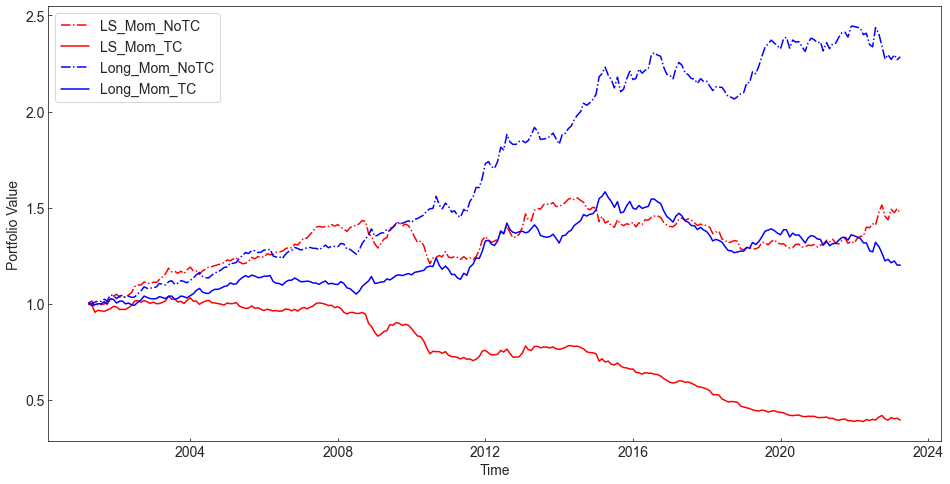

In [24]:
# Plot Strategy Performances
strategyNAV_mom = np.cumprod(1 + allTotalReturns_mom)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,1], label='LS_Mom_NoTC', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,3], label='LS_Mom_TC',color="red")
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,0], label='Long_Mom_NoTC', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_mom.iloc[:,2], label='Long_Mom_TC',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

# Carry

In [25]:
# for carry we will now calculate the differences between the long-term yields (2,5,10,20,30) and short-term yields (1M, 3M)
# we will create a dataframe for the 1M and the 3M
# I take the Yield_na for the calculation to get the same NA's as the ETF has

Carry_3m = pd.DataFrame(columns = Yield_long.columns, index = Yield_long.index)
avg_Carry_3m = pd.DataFrame(0, columns = Yield_short.columns, index = Yield_short.index)

runner = 0
counter = 0
for i in range(0,len(Yield_long.columns)):
    if counter == 5:
        runner += 1
        counter = 0
    Carry_3m.iloc[:,i] = Yield_na.iloc[:,i] - Yield_short.iloc[:,runner]
    counter += 1
    
for i in range(0,len(Yield_short.columns)):
    avg_Carry_3m.iloc[:,i] = np.nanmean([Carry_3m.iloc[:,i*5], Carry_3m.iloc[:,i*5+1], Carry_3m.iloc[:,i*5+2], Carry_3m.iloc[:,i*5+3], Carry_3m.iloc[:,i*5+4]], axis = 0)



<ipython-input-25-06346637d366>:14: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Carry_3m.iloc[:,i] = Yield_na.iloc[:,i] - Yield_short.iloc[:,runner]
<ipython-input-25-06346637d366>:18: RuntimeWarning: Mean of empty slice
  avg_Carry_3m.iloc[:,i] = np.nanmean([Carry_3m.iloc[:,i*5], Carry_3m.iloc[:,i*5+1], Carry_3m.iloc[:,i*5+2], Carry_3m.iloc[:,i*5+3], Carry_3m.iloc[:,i*5+4]], axis = 0)


# Strategy Weights

In [26]:
ETF_ret

,Germany,France,Spain,Italy,UK,Swiss comb,China,Australia,Japan,USA,Canada,Singapore,India
Datum,,,,,,,,,,,,,
2000-01-31,-0.004171,-0.005380,-0.003788,-0.002261,-0.008643,NaN,NaN,-0.002667,0.001062,NaN,NaN,NaN,NaN
2000-02-29,0.006663,0.005979,0.005704,0.005947,0.017969,NaN,NaN,0.021341,-0.005362,NaN,NaN,0.010291,NaN
2000-03-31,0.016454,0.016604,0.016070,0.013889,0.011709,NaN,NaN,0.012913,0.003724,NaN,NaN,0.004587,NaN
2000-04-28,-0.000372,-0.000371,-0.000186,0.000278,0.010394,NaN,NaN,0.003988,0.003371,NaN,NaN,0.005115,NaN
2000-05-31,0.004095,0.002878,0.002698,0.000185,0.000872,NaN,NaN,0.012299,0.006855,NaN,NaN,-0.005588,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.020856,0.021247,0.020407,0.027423,0.028590,-0.003167,0.014626,0.014057,-0.007105,0.026820,0.028205,0.024462,0.035617
2022-12-30,-0.040014,-0.046631,-0.039934,-0.045044,-0.040348,-0.026188,0.030486,-0.022093,-0.017501,-0.007295,-0.016807,0.013594,-0.014761
2023-01-31,0.016672,0.022153,0.018742,0.032246,0.026417,0.014935,0.027221,0.029014,-0.004038,0.026849,0.029945,-0.001737,0.016199


In [27]:
# weights = pd.DataFrame(columns = ETF_ret.columns, index = ETF_ret.index)

# for i,k in enumerate(ETF_ret.index):
#     temp = pmp_Sort(ETF_ret.iloc[i,:], 5,5)
#     weights.iloc[i,:] = temp
# weights

# ETF_mom = ETF_returns.copy()

# Momentum_weights = pd.DataFrame(0, columns = ETF_mom.columns, index = ETF_mom.index)
# Momentum_weights_LO = pd.DataFrame(0, columns = ETF_mom.columns, index = ETF_mom.index)

# Momentum_weights = pd.DataFrame(0,columns = ETF_mom.columns, index = ETF_mom.index)
# weights.set_index(ETF_mom.index[1:], inplace=True)
# for i in ETF_mom.columns:
#     Momentum_weights.loc["2000-01-31":,i] = weights.loc[:,i]
    
    
# for i,k in enumerate(ETF_ret.index):
#     temp = pmp_Sort(ETF_ret.iloc[i,:], 5,0)
#     weights.iloc[i,:] = temp
# weights
    
    
# Momentum_weights_LO = pd.DataFrame(0,columns = ETF_mom.columns, index = ETF_mom.index)
# weights.set_index(ETF_mom.index[1:], inplace=True)
# for i in ETF_mom.columns:
#     Momentum_weights_LO.loc["2000-01-31":,i] = weights.loc[:,i]
    
# Momentum_weights.rename(columns = {"Swiss comb": "Switzerland"}, inplace = True)
# Momentum_weights_LO.rename(columns = {"Swiss comb": "Switzerland"}, inplace = True)

In [28]:
# Momentum_weights
# Momentum_weights_LO

In [29]:
# Value
weights = pd.DataFrame(columns = Real_yield_avg.columns, index = Real_yield_avg.index)

for i,k in enumerate(Real_yield_avg.index):
    temp = pmp_Sort(Real_yield_avg.iloc[i,:], 5,5)
    weights.iloc[i,:] = temp
    
# now we need to align the columns of weights to columns of returns
ETF_value = ETF_returns.copy()
ETF_value.rename(columns = {"Swiss comb": "Switzerland"}, inplace=True)

Value_weights = pd.DataFrame(0,columns = ETF_value.columns, index = ETF_value.index)
weights.set_index(ETF_value.index[35:], inplace=True)
for i in ETF_value.columns:
    Value_weights.loc["2002-11-29":,i] = weights.loc[:,i]
    
# calculate the rf_value weight to create total returns later on

rf_value = (1-np.nansum(Value_weights, axis = 1))*rf
    
    
    
# Value Long only
weights = pd.DataFrame(columns = Real_yield_avg.columns, index = Real_yield_avg.index)

for i,k in enumerate(Real_yield_avg.index):
    temp = pmp_Sort(Real_yield_avg.iloc[i,:], 5,0)
    weights.iloc[i,:] = temp
    

# now we need to align the columns of weights to columns of returns
ETF_value = ETF_returns.copy()
ETF_value.rename(columns = {"Swiss comb": "Switzerland"}, inplace=True)

Value_weights_LO = pd.DataFrame(0,columns = ETF_value.columns, index = ETF_value.index)
weights.set_index(ETF_value.index[35:], inplace=True)
for i in ETF_value.columns:
    Value_weights_LO.loc["2002-11-29":,i] = weights.loc[:,i]

# print(Value_weights)
# print(Value_weights_LO)

In [30]:
# Momentum
Momentum_weights = momLSWeights.copy()
Momentum_weights_LO = momLongWeights.copy()
Momentum_weights.rename(columns = {"Swiss comb": "Switzerland"}, inplace = True)
Momentum_weights_LO.rename(columns = {"Swiss comb": "Switzerland"}, inplace = True)

# calculate the rf_value weight to create total returns later on

rf_momentum = (1-np.nansum(Momentum_weights, axis = 1))*rf

In [31]:
# Carry
Carry_weights = pd.DataFrame(columns = avg_Carry_3m.columns, index = avg_Carry_3m.index)

for i,k in enumerate(avg_Carry_3m.index):
    if i == 0:
        continue
    temp = pmp_Sort(avg_Carry_3m.iloc[i,:], 5, 5)
    Carry_weights.iloc[i,:] = temp

# calculate the rf_value weight to create total returns later on

rf_carry = (1-np.nansum(Carry_weights, axis = 1))*rf
    

# Carry Long only
Carry_weights_LO = pd.DataFrame(columns = avg_Carry_3m.columns, index = avg_Carry_3m.index)

for i,k in enumerate(avg_Carry_3m.index):
    if i == 0:
        continue
    temp = pmp_Sort(avg_Carry_3m.iloc[i,:], 5, 0)
    Carry_weights_LO.iloc[i,:] = temp

# print(Carry_weights)
# print(Carry_weights_LO)

# PF weights

In [32]:
# in the following we will combine the weight matrices that we've gathered sofar into two distinct weight matrices for the PF
# the PF_weight_score will be a number between -3 and 3 indicating the signals suggesting the country
# the PF_weight will just be the sum of the weights

PF_weights = Value_weights*1/3 + Carry_weights*1/3 + Momentum_weights*1/3
PF_weights_LO = Value_weights_LO*1/3 + Carry_weights_LO*1/3 + Momentum_weights_LO*1/3

# calculate the rf_value weight to create total returns later on

rf_PF = (1-np.nansum(PF_weights, axis = 1))*rf


# now we will create the scored weights
PF_score = pd.DataFrame(0, columns = Value_weights.columns, index = Value_weights.index)
PF_weights_score = pd.DataFrame(0.0, columns = Value_weights.columns, index = Value_weights.index)
PF_score_LO = pd.DataFrame(0, columns = Value_weights.columns, index = Value_weights.index)
PF_weights_score_LO = pd.DataFrame(0.0, columns = Value_weights.columns, index = Value_weights.index)

# Long short

value_pos = Value_weights > 0
value_neg = Value_weights < 0
carry_pos = Carry_weights > 0
carry_neg = Carry_weights < 0
mom_pos = Momentum_weights > 0
mom_neg = Momentum_weights < 0

PF_score[value_pos] = 1
PF_score[value_neg] = -1
PF_score[carry_pos] += 1
PF_score[carry_neg] -= 1
PF_score[mom_pos] += 1
PF_score[mom_neg] -= 1

# now we will create the weights for the PF_weights_score
for i,k in enumerate(PF_score.index):
    pos = PF_score.iloc[i,:] > 0
    neg = PF_score.iloc[i,:] < 0
    pos_sum = pos.sum()
    neg_sum = neg.sum()
    p = 1/pos_sum
    n = -1/neg_sum
    PF_weights_score.iloc[i,:][pos] = 0.2
    PF_weights_score.iloc[i,:][neg] = -0.2
    
    
# calculate the rf_value weight to create total returns later on

rf_PF_score = (1-np.nansum(PF_weights_score, axis = 1))*rf
    
# Long only

value_pos = Value_weights_LO > 0
carry_pos = Carry_weights_LO > 0
mom_pos = Momentum_weights_LO > 0

PF_score_LO[value_pos] = 1
PF_score_LO[carry_pos] += 1
PF_score_LO[mom_pos] += 1

# now we will create the weights for the PF_weights_score
for i,k in enumerate(PF_score_LO.index):
    pos = PF_score_LO.iloc[i,:] > 0
    pos_sum = pos.sum()
    p = 1/pos_sum
    PF_weights_score_LO.iloc[i,:][pos] = p

    
# print(PF_weights_score)
# print(PF_weights_score_LO)

<ipython-input-32-cb44898b2044>:41: RuntimeWarning: divide by zero encountered in longlong_scalars
  p = 1/pos_sum
<ipython-input-32-cb44898b2044>:42: RuntimeWarning: divide by zero encountered in longlong_scalars
  n = -1/neg_sum
<ipython-input-32-cb44898b2044>:65: RuntimeWarning: divide by zero encountered in longlong_scalars
  p = 1/pos_sum


# Return calculation

In [33]:
# now that we have the weights of the different strategies and the returns of the ETF's we can calculate the returns

ETF_returns.rename(columns = {'Swiss comb': 'Switzerland'}, inplace = True)

# Value
Value_returns = Value_weights.mul(ETF_returns)
Value_returns_LO = Value_weights_LO.mul(ETF_returns)
Value_ret_LS = pd.DataFrame(np.nansum(Value_returns, axis = 1), columns = ["Value LS no TC"], index = Value_returns.index)
Value_ret_LO = pd.DataFrame(np.nansum(Value_returns_LO, axis = 1), columns = ["Value LO no TC"], index = Value_returns.index)
Value_ret = pd.concat([Value_ret_LS, Value_ret_LO], axis = 1)
Value_ret_rf = Value_ret.iloc[35:,0] + rf_value.iloc[35:]
Value_ret.iloc[35:,0] = Value_ret_rf

# Carry
Carry_returns = Carry_weights.mul(ETF_returns)
Carry_returns_LO = Carry_weights_LO.mul(ETF_returns)
Carry_ret_LS = pd.DataFrame(np.nansum(Carry_returns, axis = 1), columns = ["Carry LS no TC"], index = Carry_returns.index)
Carry_ret_LO = pd.DataFrame(np.nansum(Carry_returns_LO, axis = 1), columns = ["Carry LO no TC"], index = Carry_returns.index)
Carry_ret = pd.concat([Carry_ret_LS, Carry_ret_LO], axis = 1)
Carry_ret_rf = Carry_ret.iloc[1:,0] + rf_carry.iloc[1:]
Carry_ret.iloc[1:,0] = Carry_ret_rf

# Momentum
Momentum_returns = Momentum_weights.mul(ETF_returns)
Momentum_returns_LO = Momentum_weights_LO.mul(ETF_returns)
Momentum_ret_LS = pd.DataFrame(np.nansum(Momentum_returns, axis = 1), columns = ["Momentum LS no TC"], index = Momentum_returns.index)
Momentum_ret_LO = pd.DataFrame(np.nansum(Momentum_returns_LO, axis = 1), columns = ["Momentum LO no TC"], index = Momentum_returns.index)
Momentum_ret = pd.concat([Momentum_ret_LS, Momentum_ret_LO], axis = 1)
Momentum_ret_rf = Momentum_ret.iloc[13:,0] + rf_momentum.iloc[13:]
Momentum_ret.iloc[13:,0] = Momentum_ret_rf

# PF basic
PF_basic_returns = PF_weights.mul(ETF_returns)
PF_basic_returns_LO = PF_weights_LO.mul(ETF_returns)
PF_ret_LS = pd.DataFrame(np.nansum(PF_basic_returns, axis = 1), columns = ["PF LS no TC"], index = PF_basic_returns.index)
PF_ret_LO = pd.DataFrame(np.nansum(PF_basic_returns_LO, axis = 1), columns = ["PF LO no TC"], index = PF_basic_returns.index)
PF_ret = pd.concat([PF_ret_LS, PF_ret_LO], axis = 1)
PF_ret_rf = PF_ret.iloc[1:,0] + rf_PF.iloc[1:]
PF_ret.iloc[1:,0] = PF_ret_rf

# PF scoring
PF_score_returns = PF_weights_score.mul(ETF_returns)
PF_score_returns_LO = PF_weights_score_LO.mul(ETF_returns)
PF_score_ret_LS = pd.DataFrame(np.nansum(PF_score_returns, axis = 1), columns = ["PF score LS no TC"], index = PF_score_returns.index)
PF_score_ret_LO = pd.DataFrame(np.nansum(PF_score_returns_LO, axis = 1), columns = ["PF score LO no TC"], index = PF_score_returns.index)
PF_score_ret = pd.concat([PF_score_ret_LS, PF_score_ret_LO], axis = 1)
PF_score_ret_rf = PF_score_ret.iloc[1:,0] + rf_PF_score.iloc[1:]
PF_score_ret.iloc[1:,0] = PF_score_ret_rf


# print(Value_returns)
# print(Carry_returns)
# print(Momentum_returns)
# print(PF_basic_returns)
# print(PF_score_returns)

# print(Value_returns_LO)
# print(Carry_returns_LO)
# print(Momentum_returns_LO)
# print(PF_basic_returns_LO)
# print(PF_score_returns_LO)

In [34]:
PF_weights_LO

,Germany,France,Spain,Italy,UK,Switzerland,China,Australia,Japan,USA,Canada,Singapore,India
Datum,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,0.066667,0.066667,0.066667,0.066667,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0
2000-02-29,0.066667,0.066667,0.066667,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.0
2000-03-31,0.0,0.066667,0.066667,0.066667,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.066667,0.0
2000-04-28,0.0,0.066667,0.066667,0.066667,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.0,0.133333,0.066667,0.066667,0.0,0.133333,0.2,0.133333,0.133333,0.0,0.0,0.066667,0.066667
2022-12-30,0.0,0.133333,0.066667,0.066667,0.0,0.133333,0.133333,0.2,0.133333,0.0,0.0,0.066667,0.066667
2023-01-31,0.0,0.133333,0.066667,0.066667,0.0,0.133333,0.2,0.133333,0.133333,0.0,0.0,0.066667,0.066667


# Transaction cost

In [35]:
# we will be using the ETF_returns, and the respective weights for the calcuclation of the transaction costs
# furthermore we need the return of the whole portfolio to calculate the TC

# Value

Value_ret_cut = Value_ret.iloc[34:,]

months_value = 245
Value_weights_cut = Value_weights.iloc[35:,:]
Value_weights_LO_cut = Value_weights_LO.iloc[35:,:]
ETF_value_cut = ETF_returns.iloc[35:,:]
rf_value_cut = rf[35:]

turnover_value = np.zeros((months_value,2))

for month in range(0, months_value-1):
    currentRf = rf_value_cut[month]
    currentRet = ETF_value_cut.iloc[month,:]
    turnover_value[month, 0] = computeTurnover(Value_weights_cut.iloc[month, :], Value_weights_cut.iloc[month+1, :], currentRet, currentRf)[0]
    turnover_value[month, 1] = computeTurnover(Value_weights_LO_cut.iloc[month, :], Value_weights_LO_cut.iloc[month+1, :], currentRet, currentRf)[0]

x = np.insert(turnover_value, 0, [1,1], axis = 0)
turnover_value = x.copy()
turnover_value[months_value, :] = [1,1]

avgTurnover_LSvalue = np.mean(turnover_value[:,0])
avgTurnover_Longvalue = np.mean(turnover_value[:,1])

Value_returns_TC = Value_ret_cut - (tCost * turnover_value)
Value_returns_TC.rename(columns = {"Value LS no TC": "Value LS TC", "Value LO no TC": "Value LO TC"}, inplace = True)

In [36]:
# # we will be using the ETF_returns, and the respective weights for the calcuclation of the transaction costs
# # furthermore we need the return of the whole portfolio to calculate the TC

# # Momentum

# Momentum_ret_cut = Momentum_ret.iloc[12:,]

# months_value = 245
# Value_weights_cut = Value_weights.iloc[35:,:]
# Value_weights_LO_cut = Value_weights_LO.iloc[35:,:]
# ETF_value_cut = ETF_returns.iloc[35:,:]
# rf_value_cut = rf[35:]

# turnover_value = np.zeros((months_value,2))

# for month in range(0, months_value-1):
#     currentRf = rf_value_cut[month]
#     currentRet = ETF_value_cut.iloc[month,:]
#     turnover_value[month, 0] = computeTurnover(Value_weights_cut.iloc[month, :], Value_weights_cut.iloc[month+1, :], currentRet, currentRf)[0]
#     turnover_value[month, 1] = computeTurnover(Value_weights_LO_cut.iloc[month, :], Value_weights_LO_cut.iloc[month+1, :], currentRet, currentRf)[0]

# x = np.insert(turnover_value, 0, [1,1], axis = 0)
# turnover_value = x.copy()
# turnover_value[months_value, :] = [1,1]

# avgTurnover_LSvalue = np.mean(turnover_value[:,0])
# avgTurnover_Longvalue = np.mean(turnover_value[:,1])

# Value_returns_TC = Value_ret_cut - (tCost * turnover_value)
# Value_returns_TC.rename(columns = {"Value LS no TC": "Value LS TC", "Value LO no TC": "Value LO TC"}, inplace = True)

In [37]:
# same thing for carry

Carry_ret_cut = Carry_ret.copy()

months_value = 279
Carry_weights_cut = Carry_weights.iloc[1:,:]
Carry_weights_LO_cut = Carry_weights_LO.iloc[1:,:]
ETF_value_cut = ETF_returns.iloc[1:,:]
rf_value_cut = rf[1:]

turnover_carry = np.zeros((months_value,2))

for month in range(0, months_value-1):
    currentRf = rf_value_cut[month]
    currentRet = ETF_value_cut.iloc[month,:]
    turnover_carry[month, 0] = computeTurnover(Carry_weights_cut.iloc[month, :], Carry_weights_cut.iloc[month+1, :], currentRet, currentRf)[0]
    turnover_carry[month, 1] = computeTurnover(Carry_weights_LO_cut.iloc[month, :], Carry_weights_LO_cut.iloc[month+1, :], currentRet, currentRf)[0]

x = np.insert(turnover_carry, 0, [1,1], axis = 0)
turnover_carry = x.copy()
turnover_carry[months_value] = [1,1]

avgTurnover_LScarry = np.mean(turnover_carry[:,0])
avgTurnover_Longcarry = np.mean(turnover_carry[:,1])

Carry_returns_TC = Carry_ret_cut - (tCost * turnover_carry)
Carry_returns_TC.rename(columns = {"Carry LS no TC": "Carry LS TC", "Carry LO no TC": "Carry LO TC"}, inplace = True)

In [38]:
# same thing for the PF basic

PF_ret_cut = PF_ret.copy()

months_value = 279
PF_weights_cut = PF_weights.iloc[1:,:]
PF_weights_LO_cut = PF_weights_LO.iloc[1:,:]
ETF_value_cut = ETF_returns.iloc[1:,:]
rf_value_cut = rf[1:]

turnover_PF_basic = np.zeros((months_value,2))

for month in range(0, months_value-1):
    currentRf = rf_value_cut[month]
    currentRet = ETF_value_cut.iloc[month,:]
    turnover_PF_basic[month, 0] = computeTurnover(PF_weights_cut.iloc[month, :], PF_weights_cut.iloc[month+1, :], currentRet, currentRf)[0]
    turnover_PF_basic[month, 1] = computeTurnover(PF_weights_LO_cut.iloc[month, :], PF_weights_LO_cut.iloc[month+1, :], currentRet, currentRf)[0]

x = np.insert(turnover_PF_basic, 0, [2,1], axis = 0)
turnover_PF_basic = x.copy()
turnover_PF_basic[months_value] = [3.2,3]

avgTurnover_LSPFbasic = np.mean(turnover_PF_basic[:,0])
avgTurnover_LongPFbasic = np.mean(turnover_PF_basic[:,1])

PF_returns_TC = PF_ret_cut - (tCost * turnover_PF_basic)
PF_returns_TC.rename(columns = {"PF LS no TC": "PF LS TC", "PF LO no TC": "PF LO TC"}, inplace = True)

In [39]:
# same thing for the PF scoring

PF_score_ret_cut = PF_score_ret.copy()

months_value = 279
PF_weights_score_cut = PF_weights_score.iloc[1:,:]
PF_weights_score_LO_cut = PF_weights_score_LO.iloc[1:,:]
ETF_value_cut = ETF_returns.iloc[1:,:]
rf_value_cut = rf[1:]

turnover_PF_scoring = np.zeros((months_value,2))

for month in range(0, months_value-1):
    currentRf = rf_value_cut[month]
    currentRet = ETF_value_cut.iloc[month,:]
    turnover_PF_scoring[month, 0] = computeTurnover(PF_weights_score_cut.iloc[month, :], PF_weights_score_cut.iloc[month+1, :], currentRet, currentRf)[0]
    turnover_PF_scoring[month, 1] = computeTurnover(PF_weights_score_LO_cut.iloc[month, :], PF_weights_score_LO_cut.iloc[month+1, :], currentRet, currentRf)[0]

x = np.insert(turnover_PF_scoring, 0, [2,1], axis = 0)
turnover_PF_scoring = x.copy()
turnover_PF_scoring[months_value] = [2,1]

avgTurnover_LSPFscore = np.mean(turnover_PF_scoring[:,0])
avgTurnover_LongPFscore = np.mean(turnover_PF_scoring[:,1])

PF_returns_score_TC = PF_score_ret_cut - (tCost * turnover_PF_scoring)
PF_returns_score_TC.rename(columns = {"PF score LS no TC": "PF score LS TC", "PF score LO no TC": "PF score LO TC"}, inplace = True)

In [40]:
# print(Carry_ret_cut)
# print(Carry_returns_TC)
# print(Value_ret_cut)
# print(Value_returns_TC)
# print(PF_ret_cut)
# print(PF_returns_TC)
# print(PF_score_ret_cut)
# print(PF_returns_score_TC)

# Plot Value, Carry and the PF's

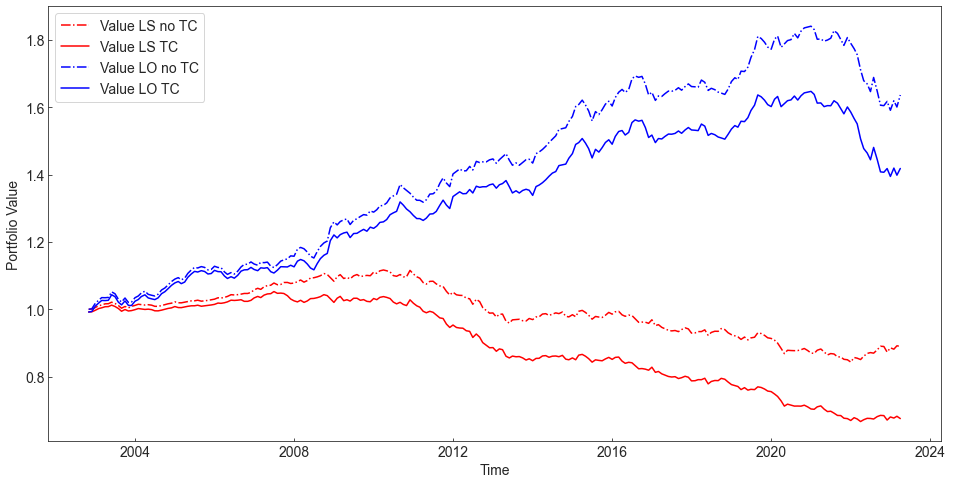

In [41]:
# Plot Strategy Performances
# Dates
dates4Fig = Value_returns_TC.index
# cum product
allTotalReturns_value = pd.concat([Value_ret_cut, Value_returns_TC], axis= 1)
strategyNAV_value = np.cumprod(1 + allTotalReturns_value)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_value.iloc[:,0], label='Value LS no TC', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_value.iloc[:,2], label='Value LS TC',color="red")
plt.plot(dates4Fig, strategyNAV_value.iloc[:,1], label='Value LO no TC', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_value.iloc[:,3], label='Value LO TC',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

In [42]:
# # Plot Strategy Performances
# strategyNAV_mom = np.cumprod(1 + allTotalReturns_mom)
# # Create the line plot
# plt.plot(dates4Fig, strategyNAV_mom.iloc[:,1], label='LS_Mom_NoTC', linestyle='dashdot',color="red")
# plt.plot(dates4Fig, strategyNAV_mom.iloc[:,3], label='LS_Mom_TC',color="red")
# plt.plot(dates4Fig, strategyNAV_mom.iloc[:,0], label='Long_Mom_NoTC', linestyle='dashdot',color="blue")
# plt.plot(dates4Fig, strategyNAV_mom.iloc[:,2], label='Long_Mom_TC',color="blue")

# # Set the x and y axis labels and legend
# plt.xlabel('Time')
# plt.ylabel('Portfolio Value')
# plt.legend()

# # Show the plot
# plt.show()

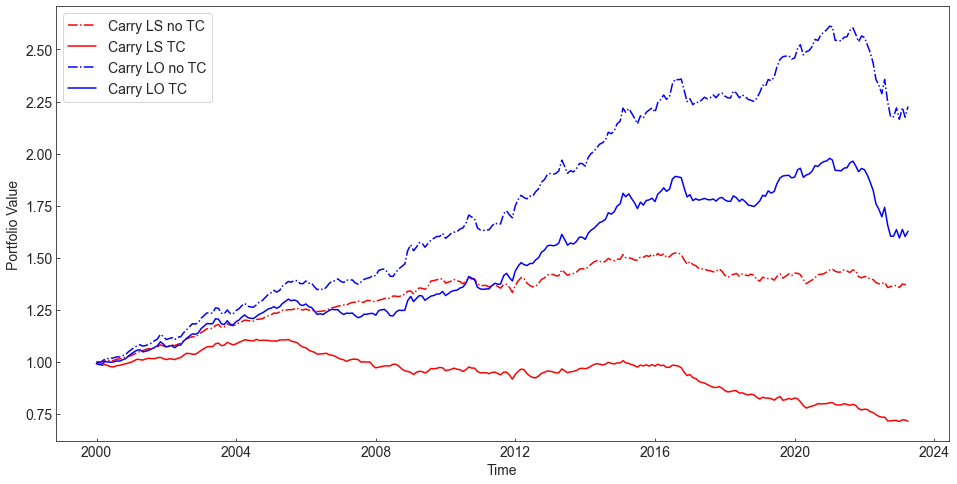

In [43]:
# Plot Strategy Performances
# Dates
dates4Fig = Carry_returns_TC.index
# cum product
allTotalReturns_carry = pd.concat([Carry_ret_cut, Carry_returns_TC], axis = 1)
strategyNAV_carry = np.cumprod(1 + allTotalReturns_carry)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_carry.iloc[:,0], label='Carry LS no TC', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_carry.iloc[:,2], label='Carry LS TC',color="red")
plt.plot(dates4Fig, strategyNAV_carry.iloc[:,1], label='Carry LO no TC', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_carry.iloc[:,3], label='Carry LO TC',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

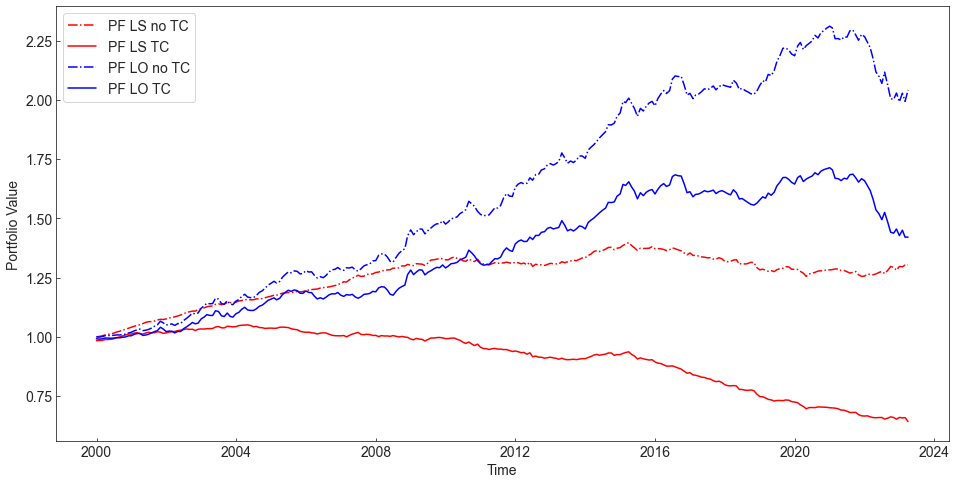

In [44]:
# Plot Strategy Performances
# Dates
dates4Fig = PF_returns_TC.index
# cum product
allTotalReturns_PF_basic = pd.concat([PF_ret_cut, PF_returns_TC], axis = 1)
strategyNAV_PF_basic = np.cumprod(1 + allTotalReturns_PF_basic)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_PF_basic.iloc[:,0], label='PF LS no TC', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_PF_basic.iloc[:,2], label='PF LS TC',color="red")
plt.plot(dates4Fig, strategyNAV_PF_basic.iloc[:,1], label='PF LO no TC', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_PF_basic.iloc[:,3], label='PF LO TC',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

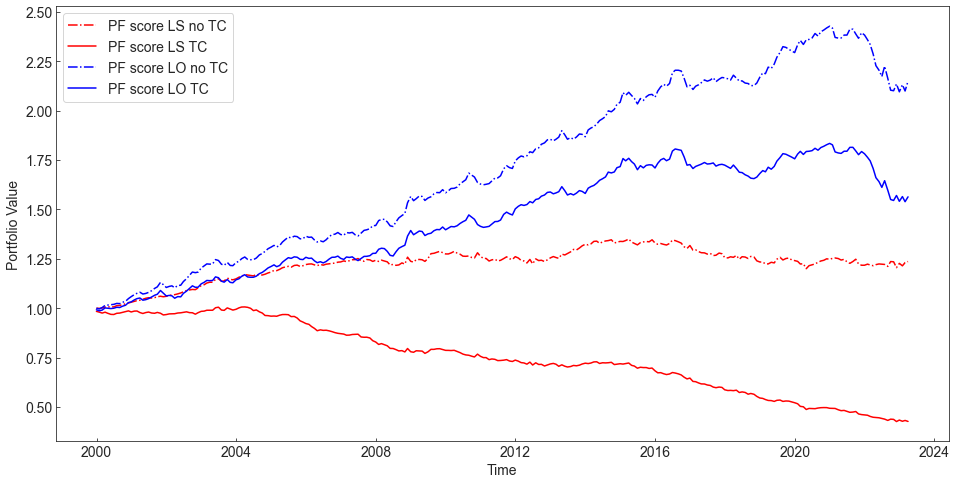

In [45]:
# Plot Strategy Performances
# Dates
dates4Fig = PF_returns_score_TC.index
# cum product
allTotalReturns_PF_score = pd.concat([PF_score_ret_cut, PF_returns_score_TC], axis = 1)
strategyNAV_PF_score = np.cumprod(1 + allTotalReturns_PF_score)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_PF_score.iloc[:,0], label='PF score LS no TC', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_PF_score.iloc[:,2], label='PF score LS TC',color="red")
plt.plot(dates4Fig, strategyNAV_PF_score.iloc[:,1], label='PF score LO no TC', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_PF_score.iloc[:,3], label='PF score LO TC',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

# Calculation of Currency Returns

In [46]:
# we will calculate the FX return for all the strategies and the PF's
FX_calc = FX_ret.iloc[11:-1,:]
FX_calc.set_index(Value_weights.index, inplace = True)

# Value
Value_LS_FX = pd.DataFrame(np.nansum(FX_calc * Value_weights, axis = 1), index = Value_weights.index, columns = ['Value LS FX'])
Value_LO_FX = pd.DataFrame(np.nansum(FX_calc * Value_weights_LO, axis = 1), index = Value_weights.index, columns = ['Value LO FX'])

# Momentum
Mom_LS_FX = pd.DataFrame(np.nansum(FX_calc * Momentum_weights, axis = 1), index = Value_weights.index, columns = ['Mom LS FX'])
Mom_LO_FX = pd.DataFrame(np.nansum(FX_calc * Momentum_weights_LO, axis = 1), index = Value_weights.index, columns = ['Mom LO FX'])

# Carry
Carry_LS_FX = pd.DataFrame(np.nansum(FX_calc * Carry_weights, axis = 1), index = Value_weights.index, columns = ['Carry LS FX'])
Carry_LO_FX = pd.DataFrame(np.nansum(FX_calc * Carry_weights_LO, axis = 1), index = Value_weights.index, columns = ['Carry LO FX'])

# PF basic
PF_LS_FX = pd.DataFrame(np.nansum(FX_calc * PF_weights, axis = 1), index = Value_weights.index, columns = ['PF LS FX'])
PF_LO_FX = pd.DataFrame(np.nansum(FX_calc * PF_weights_LO, axis = 1), index = Value_weights.index, columns = ['PF LO FX'])

# PF score
PF_LS_score_FX = pd.DataFrame(np.nansum(FX_calc * PF_weights_score, axis = 1), index = Value_weights.index, columns = ['PF LS score FX'])
PF_LO_score_FX = pd.DataFrame(np.nansum(FX_calc * PF_weights_score_LO, axis = 1), index = Value_weights.index, columns = ['PF LO score FX'])


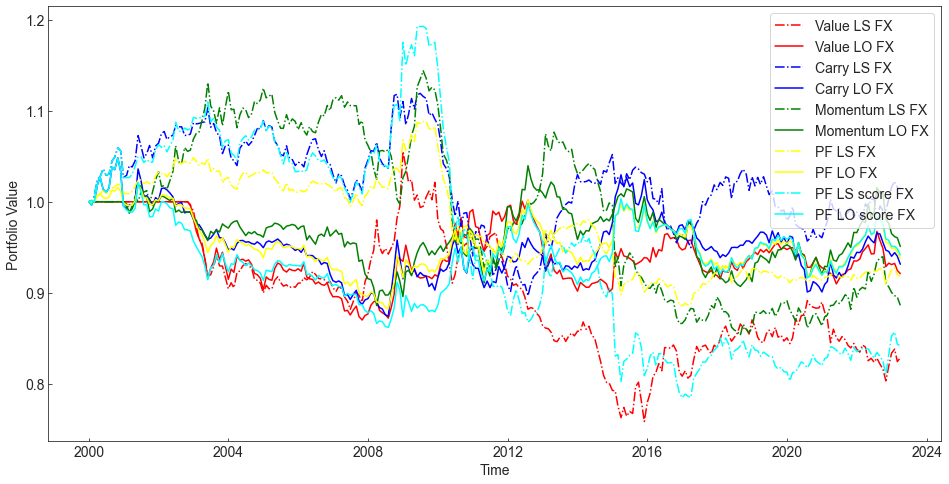

In [47]:
# Plot Strategy Performances
# Data
allTotalReturns_FX = pd.concat([Value_LS_FX, Value_LO_FX, Carry_LS_FX, Carry_LO_FX, Mom_LS_FX, Mom_LO_FX, PF_LS_FX, PF_LO_FX, PF_LS_score_FX, PF_LO_score_FX], axis = 1)
# Dates
dates4Fig = allTotalReturns_FX.index
# cum product
strategyNAV_FX = np.cumprod(1 + allTotalReturns_FX)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,0], label='Value LS FX', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,1], label='Value LO FX',color="red")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,2], label='Carry LS FX', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,3], label='Carry LO FX',color="blue")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,4], label='Momentum LS FX', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,5], label='Momentum LO FX',color="green")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,6], label='PF LS FX', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,7], label='PF LO FX',color="yellow")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,8], label='PF LS score FX', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV_FX.iloc[:,9], label='PF LO score FX',color="aqua")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

# Introduction of Futures

In [48]:
# first we have to read the file and set the index right

path = Path(r'C:\Users\Corinne Vogel\Documents\UZH\Master 2. Semester\PMP\Code\PMP-Term-Paper\Forward Hedging\Forward_long_hedge.xlsx')
#path = Path(r"/Users/thomas/Library/CloudStorage/Dropbox/00 UZH/Master/PMP/01. Offline PMP/PMP Coding/PMP-Term-Paper/Forward Hedging/Forward_long_hedge.xlsx")

Fwd_returns = pd.read_excel(path)
# note we don't have the forward return for the last datapoint --> we set index using the weights, and drop the Dates
Fwd_returns.drop(columns='Dates', inplace = True)
Fwd_returns.set_index(Carry_weights.index[:-1], inplace = True)
Fwd_returns.columns = Carry_weights.columns.values

# now the Fwd_returns have the same column names and the same index as the weight matrices

In [49]:
# we will calculate the forward return for all the strategies and the PF's

# Value
Value_LS_hedge = pd.DataFrame(np.nansum(Fwd_returns * Value_weights, axis = 1), index = Value_weights.index, columns = ['Value LS hedge'])
Value_LO_hedge = pd.DataFrame(np.nansum(Fwd_returns * Value_weights_LO, axis = 1), index = Value_weights.index, columns = ['Value LO hedge'])

# Momentum
Mom_LS_hedge = pd.DataFrame(np.nansum(Fwd_returns * Momentum_weights, axis = 1), index = Value_weights.index, columns = ['Mom LS hedge'])
Mom_LO_hedge = pd.DataFrame(np.nansum(Fwd_returns * Momentum_weights_LO, axis = 1), index = Value_weights.index, columns = ['Mom LO hedge'])

# Carry
Carry_LS_hedge = pd.DataFrame(np.nansum(Fwd_returns * Carry_weights, axis = 1), index = Value_weights.index, columns = ['Carry LS hedge'])
Carry_LO_hedge = pd.DataFrame(np.nansum(Fwd_returns * Carry_weights_LO, axis = 1), index = Value_weights.index, columns = ['Carry LO hedge'])

# PF basic
PF_LS_hedge = pd.DataFrame(np.nansum(Fwd_returns * PF_weights, axis = 1), index = Value_weights.index, columns = ['PF LS hedge'])
PF_LO_hedge = pd.DataFrame(np.nansum(Fwd_returns * PF_weights_LO, axis = 1), index = Value_weights.index, columns = ['PF LO hedge'])

# PF score
PF_LS_score_hedge = pd.DataFrame(np.nansum(Fwd_returns * PF_weights_score, axis = 1), index = Value_weights.index, columns = ['PF LS score hedge'])
PF_LO_score_hedge = pd.DataFrame(np.nansum(Fwd_returns * PF_weights_score_LO, axis = 1), index = Value_weights.index, columns = ['PF LO score hedge'])

# combine them into one Dataframe
allTotalReturns_hedge = pd.concat([Value_LS_hedge, Value_LO_hedge, Carry_LS_hedge, Carry_LO_hedge, Mom_LS_hedge, Mom_LO_hedge, PF_LS_hedge, PF_LO_hedge, PF_LS_score_hedge, PF_LO_score_hedge], axis = 1)

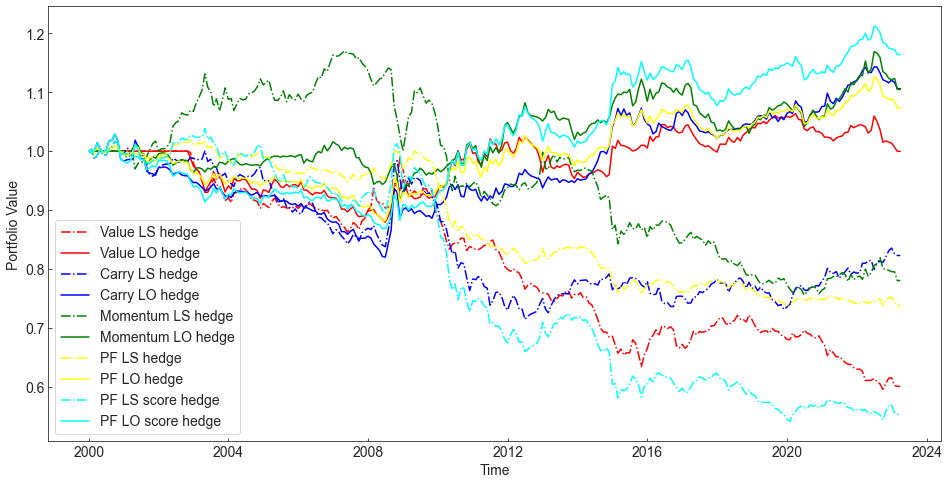

In [50]:
# Plot Strategy Performances
# Dates
dates4Fig = allTotalReturns_hedge.index
# cum product
strategyNAV_hedge = np.cumprod(1 + allTotalReturns_hedge)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,0], label='Value LS hedge', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,1], label='Value LO hedge',color="red")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,2], label='Carry LS hedge', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,3], label='Carry LO hedge',color="blue")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,4], label='Momentum LS hedge', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,5], label='Momentum LO hedge',color="green")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,6], label='PF LS hedge', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,7], label='PF LO hedge',color="yellow")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,8], label='PF LS score hedge', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV_hedge.iloc[:,9], label='PF LO score hedge',color="aqua")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

# Returns with Currency returns

In [51]:
# print(Carry_ret_cut)
# print(Carry_returns_TC)
# print(Value_ret_cut)
# print(Value_returns_TC)
# print(PF_ret_cut)
# print(PF_returns_TC)
# print(PF_score_ret_cut)
# print(PF_retrns_score_TC)
# allTotalReturns_FX

In [52]:
# we will now create two dataframes (with and without TC) and add the currency return to it
# in a second step then we will add the hedge return to the same dataframe and hopefully see some improvements from hedging

allTotalReturns_noTC_FX = pd.concat([allTotalReturns_value.iloc[:,0:2], allTotalReturns_carry.iloc[:,0:2], allTotalReturns_mom.iloc[:,1], allTotalReturns_mom.iloc[:,0], allTotalReturns_PF_basic.iloc[:,0:2], allTotalReturns_PF_score.iloc[:,0:2]], axis = 1)
allTotalReturns_TC_FX = pd.concat([allTotalReturns_value.iloc[:,2:], allTotalReturns_carry.iloc[:,2:], allTotalReturns_mom.iloc[:,3], allTotalReturns_mom.iloc[:,2], allTotalReturns_PF_basic.iloc[:,2:], allTotalReturns_PF_score.iloc[:,2:]], axis = 1)

# total returns not considering TC
for i,k in enumerate(allTotalReturns_noTC_FX.columns):
    allTotalReturns_noTC_FX.iloc[:,i] = allTotalReturns_noTC_FX.iloc[:,i] + allTotalReturns_FX.iloc[:,i]

# total returns considering TC
for i,k in enumerate(allTotalReturns_TC_FX.columns):
    allTotalReturns_TC_FX.iloc[:,i] = allTotalReturns_TC_FX.iloc[:,i] + allTotalReturns_FX.iloc[:,i]

# print(allTotalReturns_noTC)
# print(allTotalReturns_TC)

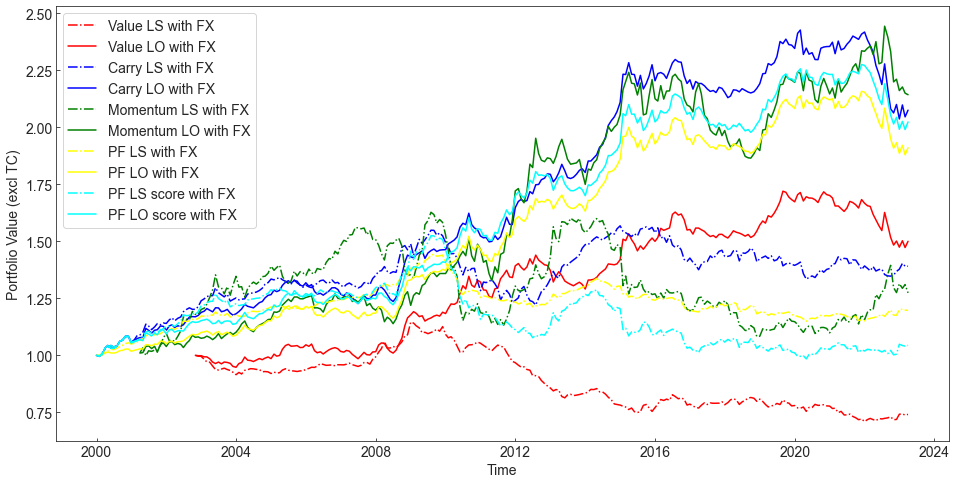

In [53]:
# Plot Strategy Performances
# Data
allTotalReturns = pd.concat([allTotalReturns_noTC_FX, allTotalReturns_TC_FX], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,0], label='Value LS with FX', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO with FX',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,2], label='Carry LS with FX', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO with FX',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LS with FX', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO with FX',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS with FX', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO with FX',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,8], label='PF LS score with FX', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,9], label='PF LO score with FX',color="aqua")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (excl TC)')
plt.legend()

# Show the plot
plt.show()

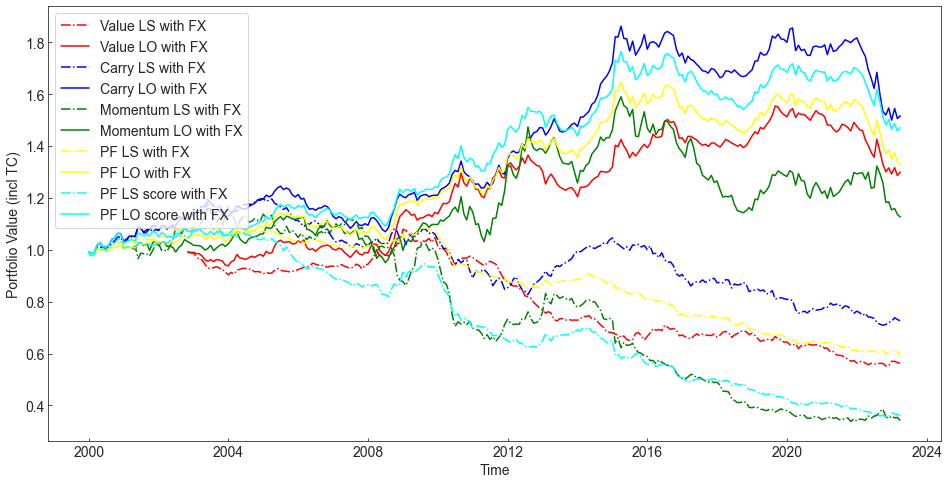

In [54]:
# Plot Strategy Performances
# Data
allTotalReturns = pd.concat([allTotalReturns_noTC_FX, allTotalReturns_TC_FX], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,10], label='Value LS with FX', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,11], label='Value LO with FX',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,12], label='Carry LS with FX', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,13], label='Carry LO with FX',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,14], label='Momentum LS with FX', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,15], label='Momentum LO with FX',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,16], label='PF LS with FX', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,17], label='PF LO with FX',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,18], label='PF LS score with FX', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,19], label='PF LO score with FX',color="aqua")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

In [55]:
# rf
# dates4Fig = rf.index
# plt.plot(dates4Fig, rf.iloc[:], label='rf',color="aqua")

# # Set the x and y axis labels and legend
# plt.xlabel('Time')
# plt.ylabel('Portfolio Value (incl TC)')
# plt.legend()

# # Show the plot
# plt.show()

# Returns with Currency hedging

In [56]:
# now we will add the Fwd_returns to the total returns

# strategy returns
allTotalReturns_noTC_hedge = pd.concat([allTotalReturns_value.iloc[:,0:2], allTotalReturns_carry.iloc[:,0:2], allTotalReturns_mom.iloc[:,1], allTotalReturns_mom.iloc[:,0], allTotalReturns_PF_basic.iloc[:,0:2], allTotalReturns_PF_score.iloc[:,0:2]], axis = 1)
allTotalReturns_TC_hedge = pd.concat([allTotalReturns_value.iloc[:,2:], allTotalReturns_carry.iloc[:,2:], allTotalReturns_mom.iloc[:,3], allTotalReturns_mom.iloc[:,2], allTotalReturns_PF_basic.iloc[:,2:], allTotalReturns_PF_score.iloc[:,2:]], axis = 1)

# total returns not considering TC
for i,k in enumerate(allTotalReturns_noTC_hedge.columns):
    allTotalReturns_noTC_hedge.iloc[:,i] = allTotalReturns_noTC_hedge.iloc[:,i] + allTotalReturns_hedge.iloc[:,i]

# total returns considering TC
for i,k in enumerate(allTotalReturns_TC_hedge.columns):
    allTotalReturns_TC_hedge.iloc[:,i] = allTotalReturns_TC_hedge.iloc[:,i] + allTotalReturns_hedge.iloc[:,i]


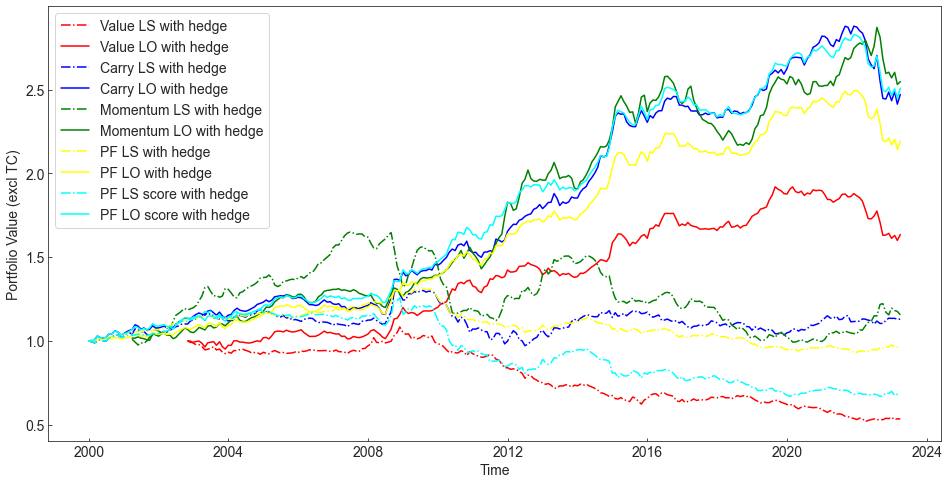

In [57]:
# Plot Strategy Performances
# Data
allTotalReturns = pd.concat([allTotalReturns_noTC_hedge, allTotalReturns_TC_hedge], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,0], label='Value LS with hedge', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO with hedge',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,2], label='Carry LS with hedge', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO with hedge',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LS with hedge', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO with hedge',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS with hedge', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO with hedge',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,8], label='PF LS score with hedge', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,9], label='PF LO score with hedge',color="aqua")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (excl TC)')
plt.legend()

# Show the plot
plt.show()

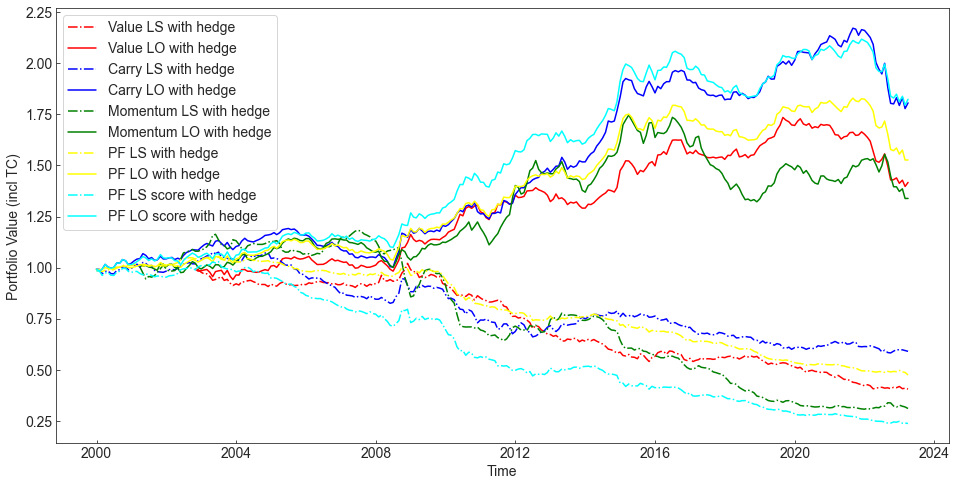

In [58]:
# Plot Strategy Performances
# Data
allTotalReturns = pd.concat([allTotalReturns_noTC_hedge, allTotalReturns_TC_hedge], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,10], label='Value LS with hedge', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,11], label='Value LO with hedge',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,12], label='Carry LS with hedge', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,13], label='Carry LO with hedge',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,14], label='Momentum LS with hedge', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,15], label='Momentum LO with hedge',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,16], label='PF LS with hedge', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,17], label='PF LO with hedge',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,18], label='PF LS score with hedge', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,19], label='PF LO score with hedge',color="aqua")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

# Summarize performance for all strategies

In [59]:
allTotalReturns_FX

,Value LS FX,Value LO FX,Carry LS FX,Carry LO FX,Mom LS FX,Mom LO FX,PF LS FX,PF LO FX,PF LS score FX,PF LO score FX
Datum,,,,,,,,,,
1999-12-31,0.0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000
2000-01-31,0.0,0.0,-0.003638,0.001331,0.000000,0.000000,-0.001213,0.000444,-0.003638,0.001331
2000-02-29,0.0,0.0,0.010813,-0.00137,0.000000,0.000000,0.003604,-0.000457,0.010813,-0.001370
2000-03-31,0.0,0.0,0.01691,0.01838,0.000000,0.000000,0.005637,0.006127,0.016910,0.018380
2000-04-28,0.0,0.0,0.003156,0.008793,0.000000,0.000000,0.001052,0.002931,0.003156,0.008793
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.019888,0.004085,0.012099,-0.001569,-0.004436,-0.004668,0.009183,-0.000717,0.027242,-0.001860
2022-12-30,0.017819,-0.001566,0.013688,-0.005569,-0.006866,-0.011697,0.008214,-0.006277,0.025206,-0.007026
2023-01-31,0.00513,0.001261,0.006284,0.004258,-0.003917,-0.003363,0.002499,0.000719,0.004865,0.000221


In [60]:
# first we need to calculate all the XS returns

allXSReturns_value = allTotalReturns_value.copy()
allXSReturns_value.iloc[1:,:] = allTotalReturns_value.iloc[1:,:].subtract(rf[35:], axis = 0)

allXSReturns_carry = allTotalReturns_carry.copy()
allXSReturns_carry.iloc[1:,:] = allTotalReturns_carry.iloc[1:,:].subtract(rf[1:], axis = 0)

allXSReturns_PF_basic = allTotalReturns_PF_basic.copy()
allXSReturns_PF_basic.iloc[1:,:] = allTotalReturns_PF_basic.iloc[1:,:].subtract(rf[1:], axis = 0)

allXSReturns_PF_score = allTotalReturns_PF_score.copy()
allXSReturns_PF_score.iloc[1:,:] = allTotalReturns_PF_score.iloc[1:,:].subtract(rf[1:], axis = 0)

# we need to have a rf with the first column being not an NA
rf_cheat = rf
rf_cheat[0] = 0
rf_cheat

# make all dataframes to floats
allXSReturns_value=allXSReturns_value.apply(pd.to_numeric)
allXSReturns_carry=allXSReturns_carry.apply(pd.to_numeric)
allXSReturns_PF_basic=allXSReturns_PF_basic.apply(pd.to_numeric)
allXSReturns_PF_score=allXSReturns_PF_score.apply(pd.to_numeric)

# finally we can calculate the performance
summarize_performance2(allXSReturns_value, rf[34:], 12, 'Value LS no TC, Value LO no TC, Value LS TC, Value LO TC')
summarize_performance2(allXSReturns_carry, rf_cheat, 12, 'Carry LS no TC, Carry LO no TC, Carry LS TC, Carry LO TC')
summarize_performance2(allXSReturns_PF_basic, rf_cheat, 12, 'PF LS no TC, PF LO no TC, PF LS TC, PF LO TC')
summarize_performance2(allXSReturns_PF_score, rf_cheat, 12, 'PF score LS no TC, PF score LO no TC, PF score LS TC, PF score LO TC')



# allTotalReturns_noTC_FX

Performance Statistics for Value LS no TC, Value LO no TC, Value LS TC, Value LO TC
skew: [-0.02738127 -0.0528786  -0.14994851 -0.11647858]
ArithmAvgTotalReturn: Value LS no TC   -0.527171
Value LO no TC    2.472768
Value LS TC      -1.869258
Value LO TC       1.772851
dtype: float64
ArithmAvgXsReturn: Value LS no TC   -1.270735
Value LO no TC    1.729205
Value LS TC      -2.612822
Value LO TC       1.029287
dtype: float64
StdXsReturns: Value LS no TC    2.357874
Value LO no TC    3.316921
Value LS TC       2.395920
Value LO TC       3.288576
dtype: float64
SharpeArithmetic: Value LS no TC   -0.538932
Value LO no TC    0.521328
Value LS TC      -1.090530
Value LO TC       0.312989
dtype: float64
GeomAvgTotalReturn: Value LS no TC   -0.554465
Value LO no TC    2.445010
Value LS TC      -1.882542
Value LO TC       1.732579
dtype: float64
GeomAvgXsReturn: Value LS no TC   -1.299555
Value LO no TC    1.699920
Value LS TC      -2.627632
Value LO TC       0.987489
dtype: float64
SharpeGeomet

C:\Users\Corinne Vogel\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


# Benchmarking

In [61]:
# firstly we will calculate the benchmark weights (equal weights)

Benchmark_weights = ETF_returns.notna()
Benchmark_weights = Benchmark_weights.astype(int)
for i,k in enumerate(Benchmark_weights.index):
    if i == 0:
        continue
    s = sum(Benchmark_weights.iloc[i,:])
    s = 1/s
    Benchmark_weights.iloc[i,:] = Benchmark_weights.iloc[i,:] * s

#Benchmark_weights

In [62]:
# next we will calculate the benchmark returns

Benchmark_returns = ETF_returns * Benchmark_weights

# then we will sum up the returns for each month

Benchmark_ret = pd.DataFrame(np.nansum(Benchmark_returns, axis = 1), index = Benchmark_returns.index, columns = ["Benchmark return"])

# next we will calculate the turnover for the benchmark in order to calculate the transaction cost

Benchmark_ret_cut = Benchmark_ret.copy()

months_Benchmark = 279
Benchmark_weights_cut = Benchmark_weights.iloc[1:,:]
ETF_Benchmark_cut = ETF_returns.iloc[1:,:]
rf_Benchmark_cut = rf[1:]

turnover_Benchmark = np.zeros((months_Benchmark,1))

for month in range(0, months_Benchmark-1):
    currentRf = rf_Benchmark_cut[month]
    currentRet = ETF_Benchmark_cut.iloc[month,:]
    turnover_Benchmark[month] = computeTurnover(Benchmark_weights_cut.iloc[month, :], Benchmark_weights_cut.iloc[month+1, :], currentRet, currentRf)[0]

x = np.insert(turnover_Benchmark, 0, [1], axis = 0)
turnover_Benchmark = x.copy()
turnover_Benchmark[months_Benchmark] = [1]

avgTurnover_LSBenchmark = np.mean(turnover_Benchmark)

Benchmark_returns_TC = Benchmark_ret_cut - (tCost * turnover_Benchmark)
Benchmark_returns_TC.rename(columns = {"Benchmark return": "Benchmark return incl TC"}, inplace = True)

# create Benchmark combined with FX
Benchmark_FX = pd.DataFrame(np.nansum(FX_calc * Benchmark_weights, axis = 1), index = Value_weights.index, columns = ['Benchmark FX'])

Benchmark_FX_TC = pd.DataFrame(columns = ["Benchmark FX incl. TC"], index = Benchmark_FX.index)
for i,k in enumerate(Benchmark_returns_TC.columns):
    Benchmark_FX_TC.iloc[:,i] = Benchmark_FX.iloc[:,i] + Benchmark_returns_TC.iloc[:,i]
    
for i,k in enumerate(Benchmark_ret.columns):
    Benchmark_FX.iloc[:,i] = Benchmark_FX.iloc[:,i] + Benchmark_ret.iloc[:,i]
    
# create Benchmark combined with hedge
Benchmark_hedge = pd.DataFrame(np.nansum(Fwd_returns * Benchmark_weights, axis = 1), index = Value_weights.index, columns = ['Benchmark hedge'])

Benchmark_hedge_TC = pd.DataFrame(columns = ["Benchmark hedge incl. TC"], index = Benchmark_hedge.index)
for i,k in enumerate(Benchmark_hedge_TC.columns):
    Benchmark_hedge_TC.iloc[:,i] = Benchmark_hedge.iloc[:,i] + Benchmark_returns_TC.iloc[:,i]
    
for i,k in enumerate(Benchmark_ret.columns):
    Benchmark_hedge.iloc[:,i] = Benchmark_hedge.iloc[:,i] + Benchmark_ret.iloc[:,i]


<ipython-input-62-b37df7d94951>:39: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Benchmark_FX_TC.iloc[:,i] = Benchmark_FX.iloc[:,i] + Benchmark_returns_TC.iloc[:,i]
<ipython-input-62-b37df7d94951>:49: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Benchmark_hedge_TC.iloc[:,i] = Benchmark_hedge.iloc[:,i] + Benchmark_returns_TC.iloc[:,i]


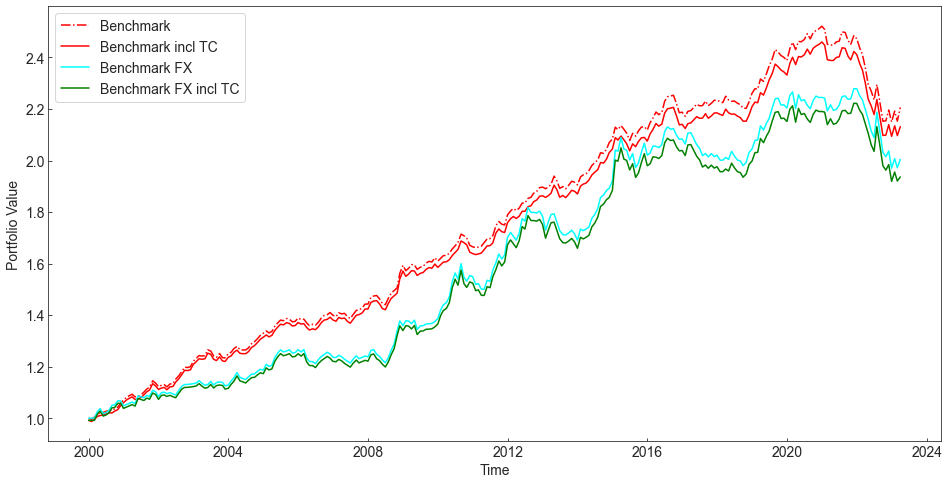

In [63]:
# Plot Benchmark Performances
# Data
allTotalReturns_Benchmark = pd.concat([Benchmark_ret, Benchmark_returns_TC, Benchmark_FX, Benchmark_FX_TC, Benchmark_hedge, Benchmark_hedge_TC], axis = 1)
# Dates
dates4Fig = allTotalReturns_Benchmark.index
# cum product
strategyNAV_Benchmark = np.cumprod(1 + allTotalReturns_Benchmark)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,0], label='Benchmark', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,1], label='Benchmark incl TC',color="red")
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,2], label='Benchmark FX',color="aqua")
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,3], label='Benchmark FX incl TC',color="green")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

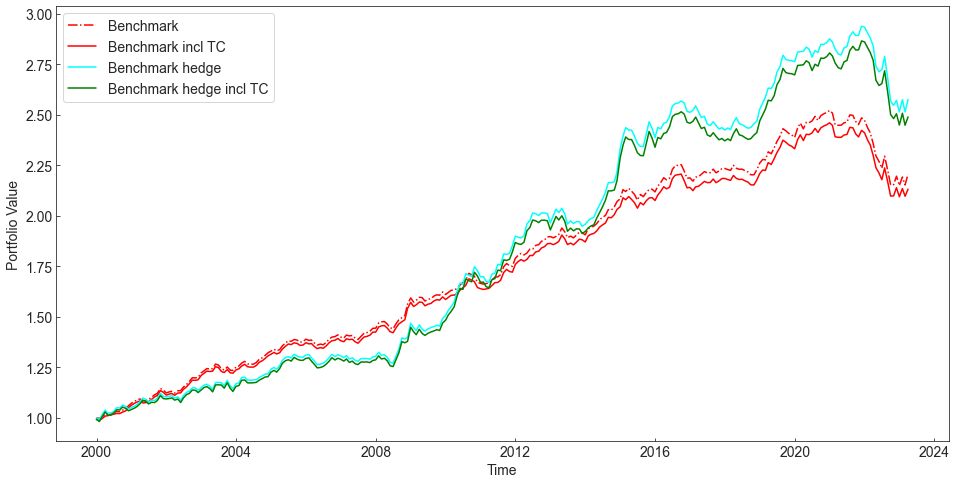

In [64]:
# Plot Benchmark Performances
# Data# Dates
dates4Fig = allTotalReturns_Benchmark.index
# cum product
strategyNAV_Benchmark = np.cumprod(1 + allTotalReturns_Benchmark)
# Create the line plot
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,0], label='Benchmark', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,1], label='Benchmark incl TC',color="red")
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,4], label='Benchmark hedge',color="aqua")
plt.plot(dates4Fig, strategyNAV_Benchmark.iloc[:,5], label='Benchmark hedge incl TC',color="green")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()

# Show the plot
plt.show()

# Plot gallery

In [65]:
allTotalReturns_noTC_FX

,Value LS no TC,Value LO no TC,Carry LS no TC,Carry LO no TC,LS_Mom_NoTC,Long_Mom_NoTC,PF LS no TC,PF LO no TC,PF score LS no TC,PF score LO no TC
1999-12-31,NaN,NaN,0,0,NaN,NaN,0,0,0.000000,0.000000
2000-01-31,NaN,NaN,-0.00459,-0.002323,NaN,NaN,0.000445,-0.000774,-0.004590,-0.002323
2000-02-29,NaN,NaN,0.01268,0.005547,NaN,NaN,0.00616,0.001849,0.012680,0.005547
2000-03-31,NaN,NaN,0.021602,0.029355,NaN,NaN,0.009348,0.009785,0.021602,0.029355
2000-04-28,NaN,NaN,0.003848,0.010435,NaN,NaN,0.003341,0.003478,0.003848,0.010435
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.001235,0.012017,0.011732,0.017983,-0.016640,0.005323,-0.000337,0.01274,0.003203,0.014536
2022-12-30,0.032203,-0.017951,0.007156,-0.030213,0.030735,-0.022598,0.020925,-0.024417,0.043207,-0.025701
2023-01-31,0.000672,0.019118,0.018319,0.030134,-0.015580,0.007413,0.001235,0.018802,-0.005309,0.017414
2023-02-28,-0.004911,-0.01977,-0.008471,-0.024911,0.012681,-0.012472,-0.002605,-0.021551,-0.002595,-0.017684


In [66]:
# concatenate to ease the plotting
allTotalReturns_TC_FX = pd.concat([allTotalReturns_TC_FX, allTotalReturns_Benchmark.iloc[:,3]], axis = 1)
allTotalReturns_TC_hedge = pd.concat([allTotalReturns_TC_hedge, allTotalReturns_Benchmark.iloc[:,5]], axis = 1)
allTotalReturns_noTC_FX = pd.concat([allTotalReturns_noTC_FX, allTotalReturns_Benchmark.iloc[:,2]], axis = 1)

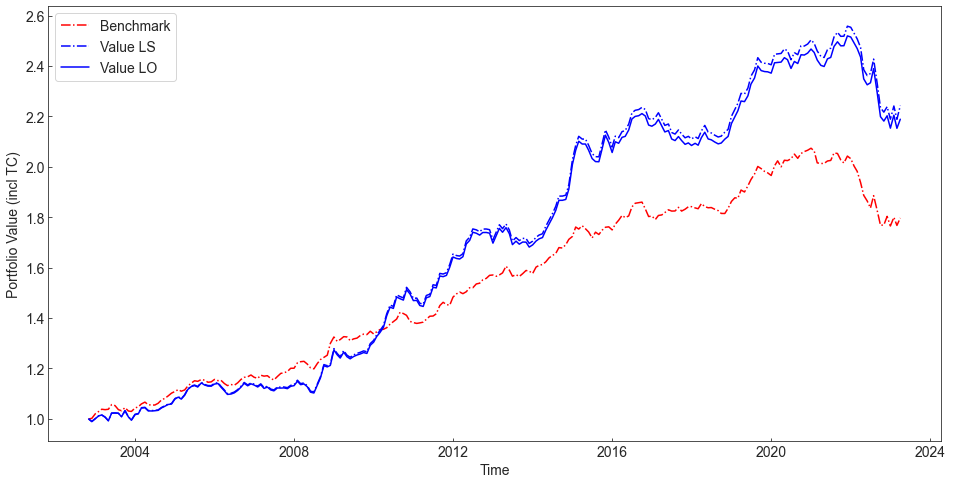

In [67]:
# Plot Benchmark & Value Performances
# Data
allTotalReturns = pd.concat([allTotalReturns_Benchmark.iloc[34:,:], allTotalReturns_value], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Benchmark', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='Value LS', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='Value LO',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

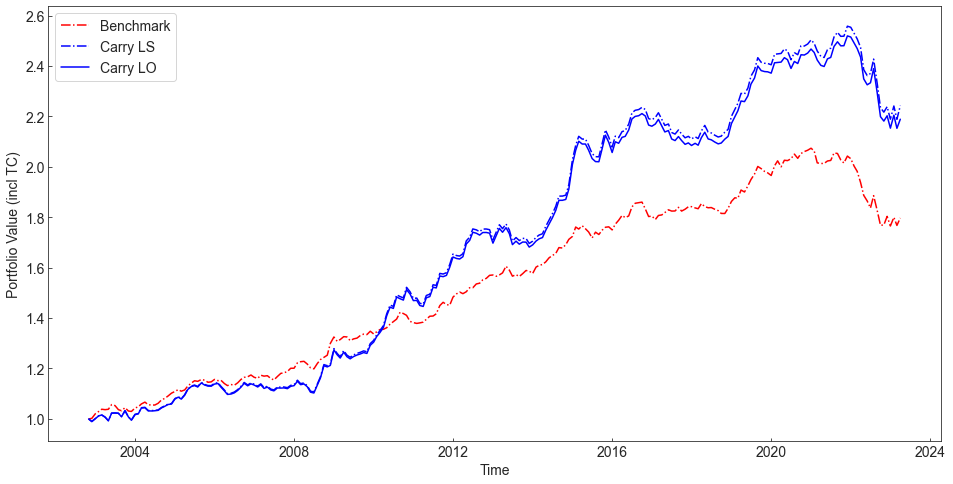

In [68]:
# Plot Benchmark & Carry performances
# Data
allTotalReturns = pd.concat([allTotalReturns_Benchmark.iloc[34:,:], allTotalReturns_carry.iloc[34:,:]], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Benchmark', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='Carry LS', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='Carry LO',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

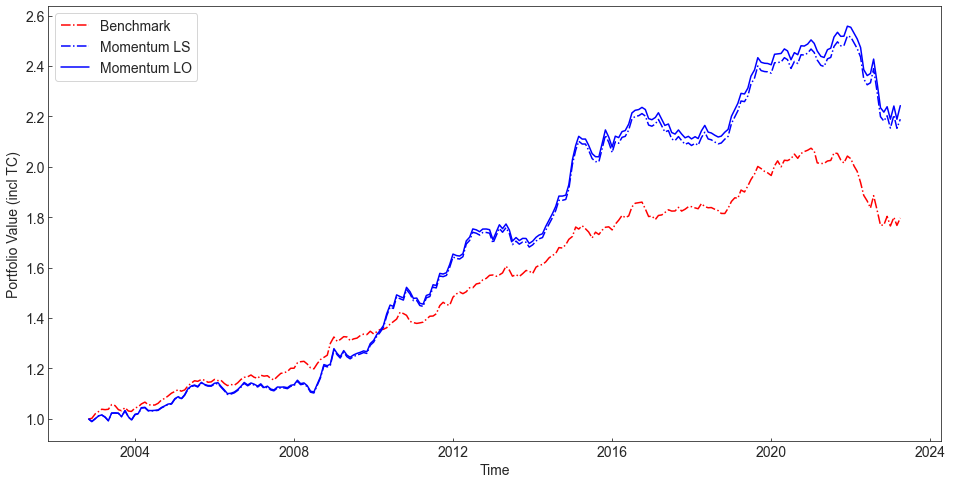

In [69]:
# Plot Benchmark & Momentum performances
# Data
allTotalReturns = pd.concat([allTotalReturns_Benchmark.iloc[34:,:], allTotalReturns_mom.iloc[20:,:]], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Benchmark', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LS', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LO',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

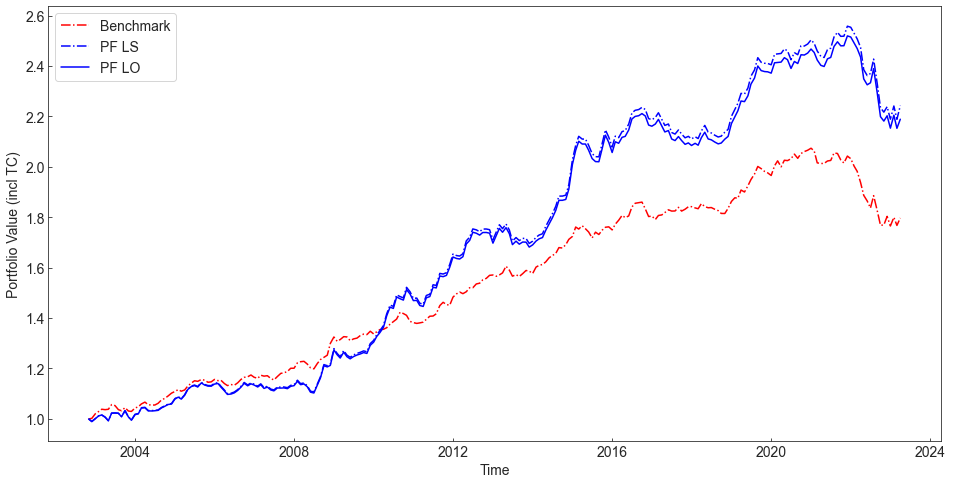

In [70]:
# Plot Benchmark & Strategy basic performances
# Data
allTotalReturns = pd.concat([allTotalReturns_Benchmark.iloc[34:,:], allTotalReturns_PF_basic.iloc[34:,:]], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Benchmark', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='PF LS', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='PF LO',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

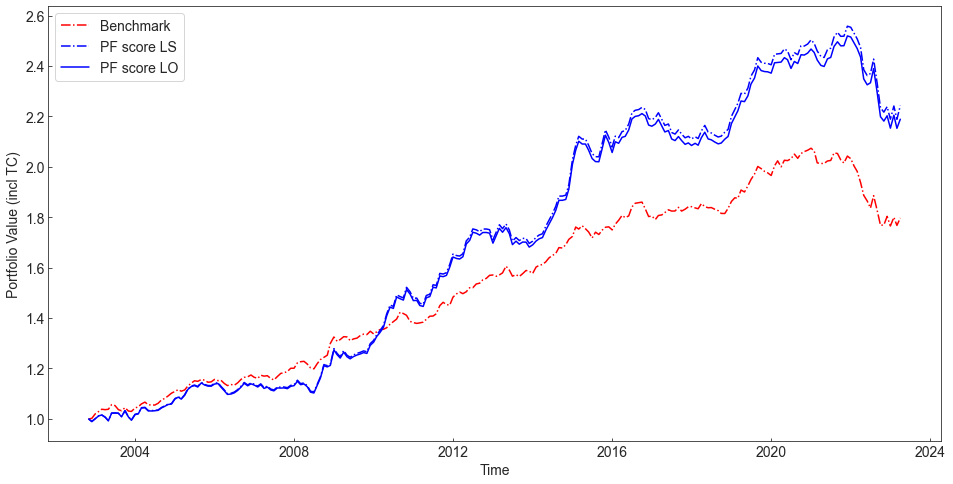

In [71]:
# Plot Benchmark & Strategy basic performances
# Data
allTotalReturns = pd.concat([allTotalReturns_Benchmark.iloc[34:,:], allTotalReturns_PF_score.iloc[34:,:]], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Benchmark', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='PF score LS', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='PF score LO',color="blue")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

In [72]:
# Value - Bench, Mom - Bench, Carry - Bench, PF - Bench, PF score - Bench --> once for FX, once for hedge
# all with FX, all with hedge
allTotalReturns_TC_FX
# allTotalReturns_TC_hedge

,Value LS TC,Value LO TC,Carry LS TC,Carry LO TC,LS_Mom_TC,Long_Mom_TC,PF LS TC,PF LO TC,PF score LS TC,PF score LO TC,Benchmark FX incl. TC
1999-12-31,NaN,NaN,-0.008,-0.008,NaN,NaN,-0.016,-0.008,-0.016000,-0.008000,-0.008000
2000-01-31,NaN,NaN,-0.007822,-0.00393,NaN,NaN,-0.000637,-0.001316,-0.007822,-0.003930,-0.000193
2000-02-29,NaN,NaN,0.006195,0.002337,NaN,NaN,0.004001,0.000775,0.006195,0.002337,0.000048
2000-03-31,NaN,NaN,0.021506,0.029312,NaN,NaN,0.009313,0.009768,0.021506,0.029312,0.024368
2000-04-28,NaN,NaN,-0.002583,0.007224,NaN,NaN,0.001201,0.002409,-0.002583,0.007224,0.011773
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.000639,0.011934,0.011391,0.01795,-0.020308,0.002023,-0.001614,0.011596,0.002430,0.014454,0.011006
2022-12-30,0.031563,-0.018104,0.006743,-0.030402,0.026591,-0.025958,0.019638,-0.02551,0.042470,-0.025857,-0.032822
2023-01-31,0.000267,0.01904,0.018141,0.0301,-0.019234,0.004126,-0.001047,0.016669,-0.009074,0.015814,0.018799
2023-02-28,-0.008484,-0.023055,-0.008751,-0.024944,0.005833,-0.018959,-0.005863,-0.024742,-0.006244,-0.019290,-0.017811


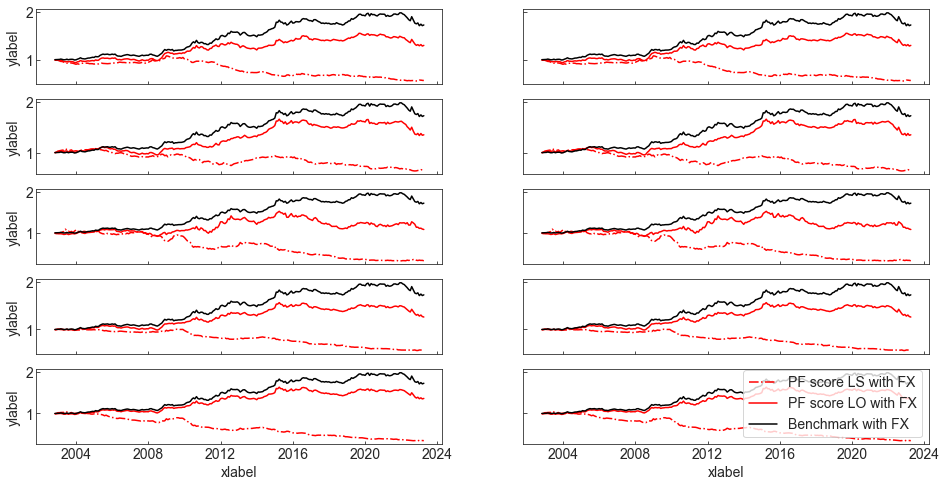

In [73]:
# all strategies against benchmark with FX or hedge
# Data
allTotalReturns = allTotalReturns_TC_FX.iloc[34:,:]
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
fig, axs = plt.subplots(5,2)
axs[0,0].plot(dates4Fig, strategyNAV.iloc[:,0], label='Value LS with FX', linestyle='dashdot',color="red")
axs[0,0].plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO with FX',color="red")
axs[0,0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[0,0].set_title("")

axs[1,0].plot(dates4Fig, strategyNAV.iloc[:,2], label='Carry LS with FX', linestyle='dashdot',color="red")
axs[1,0].plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO with FX',color="red")
axs[1,0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[1,0].set_title("")

axs[2,0].plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LS with FX', linestyle='dashdot',color="red")
axs[2,0].plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO with FX',color="red")
axs[2,0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[2,0].set_title("")

axs[3,0].plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS with FX', linestyle='dashdot',color="red")
axs[3,0].plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO with FX',color="red")
axs[3,0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[3,0].set_title("")

axs[4,0].plot(dates4Fig, strategyNAV.iloc[:,8], label='PF score LS with FX', linestyle='dashdot',color="red")
axs[4,0].plot(dates4Fig, strategyNAV.iloc[:,9], label='PF score LO with FX',color="red")
axs[4,0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[4,0].set_title("")

axs[0,1].plot(dates4Fig, strategyNAV.iloc[:,0], label='Value LS with FX', linestyle='dashdot',color="red")
axs[0,1].plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO with FX',color="red")
axs[0,1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[0,1].set_title("")

axs[1,1].plot(dates4Fig, strategyNAV.iloc[:,2], label='Carry LS with FX', linestyle='dashdot',color="red")
axs[1,1].plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO with FX',color="red")
axs[1,1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[1,1].set_title("")

axs[2,1].plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LS with FX', linestyle='dashdot',color="red")
axs[2,1].plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO with FX',color="red")
axs[2,1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[2,1].set_title("")

axs[3,1].plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS with FX', linestyle='dashdot',color="red")
axs[3,1].plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO with FX',color="red")
axs[3,1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[3,1].set_title("")

axs[4,1].plot(dates4Fig, strategyNAV.iloc[:,8], label='PF score LS with FX', linestyle='dashdot',color="red")
axs[4,1].plot(dates4Fig, strategyNAV.iloc[:,9], label='PF score LO with FX',color="red")
axs[4,1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark with FX', color="black")
axs[4,1].set_title("")
axs[4,1].legend()


# Set the x and y axis labels and legend
for ax in axs.flat:
    ax.set(xlabel = "xlabel", ylabel = "ylabel")
for ax in axs.flat:
    ax.label_outer()


In [74]:
allTotalReturns_noTC_FX

,Value LS no TC,Value LO no TC,Carry LS no TC,Carry LO no TC,LS_Mom_NoTC,Long_Mom_NoTC,PF LS no TC,PF LO no TC,PF score LS no TC,PF score LO no TC,Benchmark FX
1999-12-31,NaN,NaN,0,0,NaN,NaN,0,0,0.000000,0.000000,0.000000
2000-01-31,NaN,NaN,-0.00459,-0.002323,NaN,NaN,0.000445,-0.000774,-0.004590,-0.002323,0.000807
2000-02-29,NaN,NaN,0.01268,0.005547,NaN,NaN,0.00616,0.001849,0.012680,0.005547,0.000096
2000-03-31,NaN,NaN,0.021602,0.029355,NaN,NaN,0.009348,0.009785,0.021602,0.029355,0.024400
2000-04-28,NaN,NaN,0.003848,0.010435,NaN,NaN,0.003341,0.003478,0.003848,0.010435,0.011796
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.001235,0.012017,0.011732,0.017983,-0.016640,0.005323,-0.000337,0.01274,0.003203,0.014536,0.011078
2022-12-30,0.032203,-0.017951,0.007156,-0.030213,0.030735,-0.022598,0.020925,-0.024417,0.043207,-0.025701,-0.032679
2023-01-31,0.000672,0.019118,0.018319,0.030134,-0.015580,0.007413,0.001235,0.018802,-0.005309,0.017414,0.018867
2023-02-28,-0.004911,-0.01977,-0.008471,-0.024911,0.012681,-0.012472,-0.002605,-0.021551,-0.002595,-0.017684,-0.017743


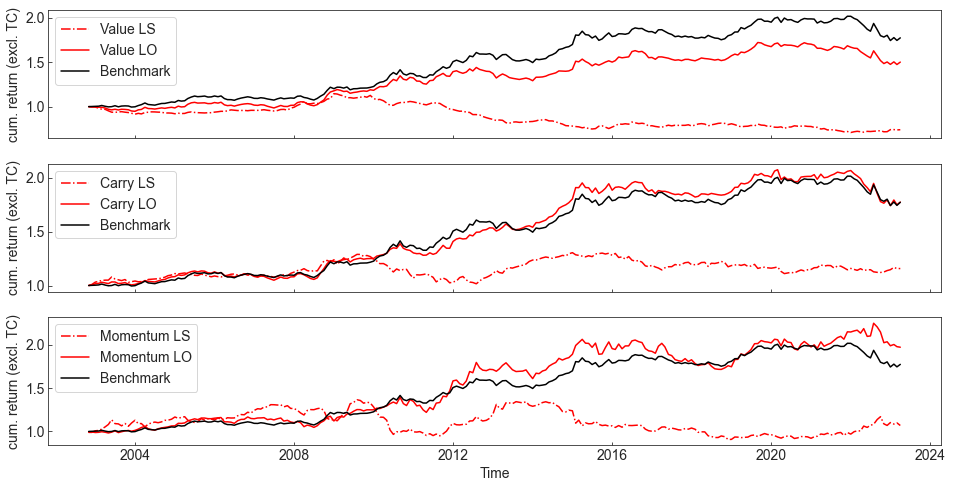

In [75]:
# all strategies against benchmark with FX or hedge
# Data
allTotalReturns = allTotalReturns_noTC_FX.iloc[34:,:]
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
fig, axs = plt.subplots(3,1)
axs[0].plot(dates4Fig, strategyNAV.iloc[:,0], label='Value LS', linestyle='dashdot',color="red")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO',color="red")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[0].set_title("")
axs[0].legend()

axs[1].plot(dates4Fig, strategyNAV.iloc[:,2], label='Carry LS', linestyle='dashdot',color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO',color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[1].set_title("")
axs[1].legend()

axs[2].plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LS', linestyle='dashdot',color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO',color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[2].set_title("")
axs[2].legend()


# Set the x and y axis labels and legend

for ax in axs.flat:
    ax.set(xlabel = "Time", ylabel = "cum. return (excl. TC)")
for ax in axs.flat:
    ax.label_outer()
plt.savefig("Pictures/all_3_unhedged_1.png")

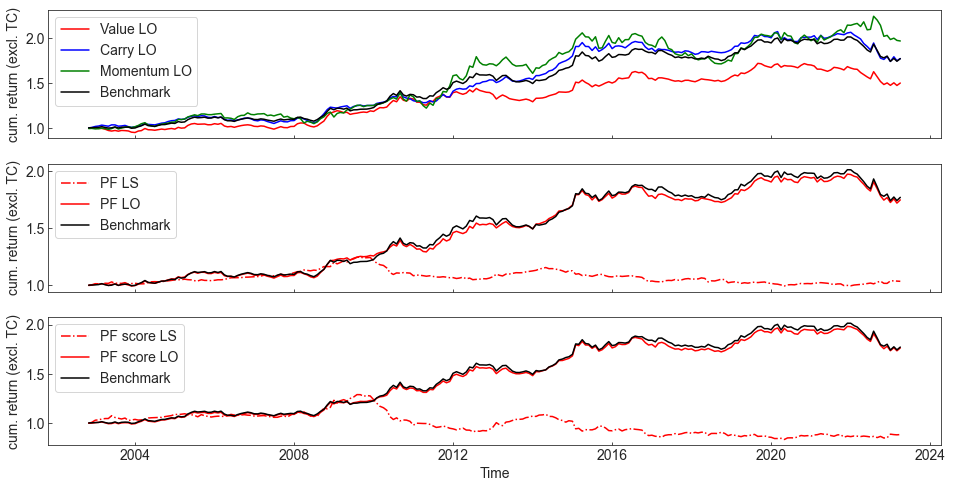

In [76]:
# all strategies against benchmark with FX or hedge
# Data
allTotalReturns = allTotalReturns_noTC_FX.iloc[34:,:]
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
fig, axs = plt.subplots(3,1)
axs[0].plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO',color="red")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO',color="blue")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO',color="green")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[0].set_title("")
axs[0].legend()

axs[1].plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS',linestyle = "dashdot",color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO',  color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[1].set_title("")
axs[1].legend()

axs[2].plot(dates4Fig, strategyNAV.iloc[:,8], label='PF score LS', linestyle = "dashdot", color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,9], label='PF score LO',color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[2].set_title("")
axs[2].legend(loc = 2)


# Set the x and y axis labels and legend

for ax in axs.flat:
    ax.set(xlabel = "Time", ylabel = "cum. return (excl. TC)")
for ax in axs.flat:
    ax.label_outer()

plt.savefig("Pictures/all_5_unhedged_2.png")

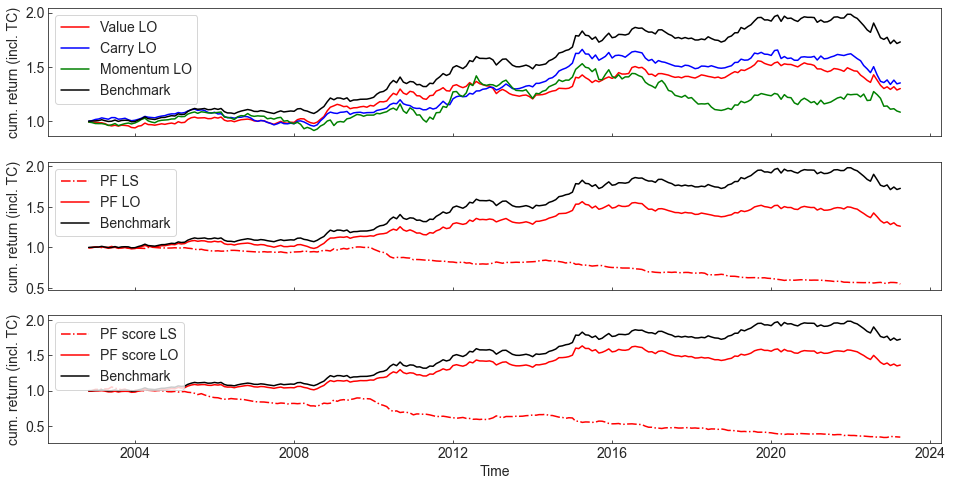

In [77]:
# all strategies against benchmark with FX or hedge
# Data
allTotalReturns = allTotalReturns_TC_FX.iloc[34:,:]
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
fig, axs = plt.subplots(3,1)
axs[0].plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO',color="red")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO',color="blue")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO',color="green")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[0].set_title("")
axs[0].legend()

axs[1].plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS',linestyle = "dashdot",color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO',  color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[1].set_title("")
axs[1].legend()

axs[2].plot(dates4Fig, strategyNAV.iloc[:,8], label='PF score LS', linestyle = "dashdot", color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,9], label='PF score LO',color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark', color="black")
axs[2].set_title("")
axs[2].legend(loc = 2)


# Set the x and y axis labels and legend

for ax in axs.flat:
    ax.set(xlabel = "Time", ylabel = "cum. return (incl. TC)")
for ax in axs.flat:
    ax.label_outer()

plt.savefig("Pictures/all_3_unhedged_TC_3.png")

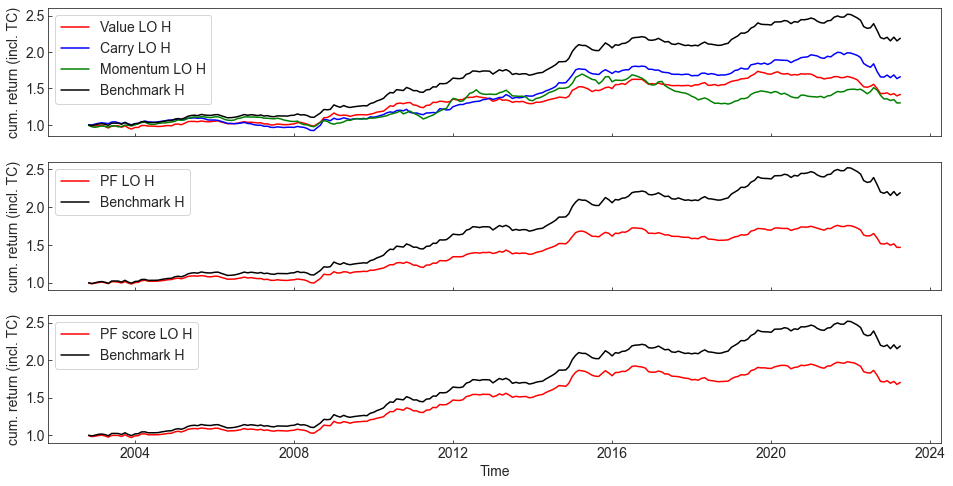

In [102]:
# all strategies against benchmark with FX or hedge
# Data
allTotalReturns = allTotalReturns_TC_hedge.iloc[34:,:]
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
fig, axs = plt.subplots(3,1)
axs[0].plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO H',color="red")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO H',color="blue")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO H',color="green")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark H', color="black")
axs[0].set_title("")
axs[0].legend()

#axs[1].plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS H',linestyle = "dashdot",color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO H',  color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark H', color="black")
axs[1].set_title("")
axs[1].legend()

#axs[2].plot(dates4Fig, strategyNAV.iloc[:,8], label='PF score LS H', linestyle = "dashdot", color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,9], label='PF score LO H',color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,10], label='Benchmark H', color="black")
axs[2].set_title("")
axs[2].legend(loc = 2)


# Set the x and y axis labels and legend

for ax in axs.flat:
    ax.set(xlabel = "Time", ylabel = "cum. return (incl. TC)")
for ax in axs.flat:
    ax.label_outer()

plt.savefig("Pictures/all_5_hedged_TC_4.png")


In [79]:
allTotalReturns_TC_hedge

,Value LS TC,Value LO TC,Carry LS TC,Carry LO TC,LS_Mom_TC,Long_Mom_TC,PF LS TC,PF LO TC,PF score LS TC,PF score LO TC,Benchmark hedge incl. TC
1999-12-31,NaN,NaN,-0.008,-0.008,NaN,NaN,-0.016,-0.008,-0.016000,-0.008000,-0.008000
2000-01-31,NaN,NaN,-0.000962,-0.008045,NaN,NaN,0.001649,-0.002687,-0.000962,-0.008045,-0.010971
2000-02-29,NaN,NaN,-0.021831,0.007753,NaN,NaN,-0.005341,0.002581,-0.021831,0.007753,0.024335
2000-03-31,NaN,NaN,0.012304,0.023932,NaN,NaN,0.006245,0.007974,0.012304,0.023932,0.023395
2000-04-28,NaN,NaN,0.002555,-0.011797,NaN,NaN,0.002914,-0.003932,0.002555,-0.011797,-0.015216
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.0045,0.006025,0.012231,0.01692,-0.016919,-0.000422,-0.001917,0.008468,-0.004823,0.010289,0.009622
2022-12-30,0.014601,-0.018299,-0.001414,-0.020845,0.030426,-0.016183,0.012543,-0.019131,0.017504,-0.019766,-0.022270
2023-01-31,-0.026088,0.01067,0.000193,0.02224,-0.015609,0.009428,-0.014606,0.013026,-0.037936,0.014480,0.023867
2023-02-28,0.005359,-0.02155,-0.005642,-0.030033,-0.011171,-0.034251,-0.00588,-0.031034,0.005593,-0.023639,-0.023601


In [108]:
allTotalReturns

,Value LS no TC,Value LO no TC,Carry LS no TC,Carry LO no TC,LS_Mom_NoTC,Long_Mom_NoTC,PF LS no TC,PF LO no TC,PF score LS no TC,PF score LO no TC,Benchmark hedge,Benchmark FX
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000807
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000096
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024400
2000-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011796
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.003904,0.006108,0.012572,0.016953,-0.013252,0.002879,-0.00064,0.009612,-0.004050,0.010372,0.009694,0.011078
2022-12-30,0.01524,-0.018146,-0.001001,-0.020656,0.034570,-0.012823,0.01383,-0.018038,0.018242,-0.019609,-0.022127,-0.032679
2023-01-31,-0.025683,0.010748,0.000371,0.022274,-0.011955,0.012715,-0.012324,0.015159,-0.034171,0.016080,0.023935,0.018867
2023-02-28,0.008932,-0.018265,-0.005362,-0.03,-0.004322,-0.027765,-0.002623,-0.027844,0.009241,-0.022033,-0.023533,-0.017743


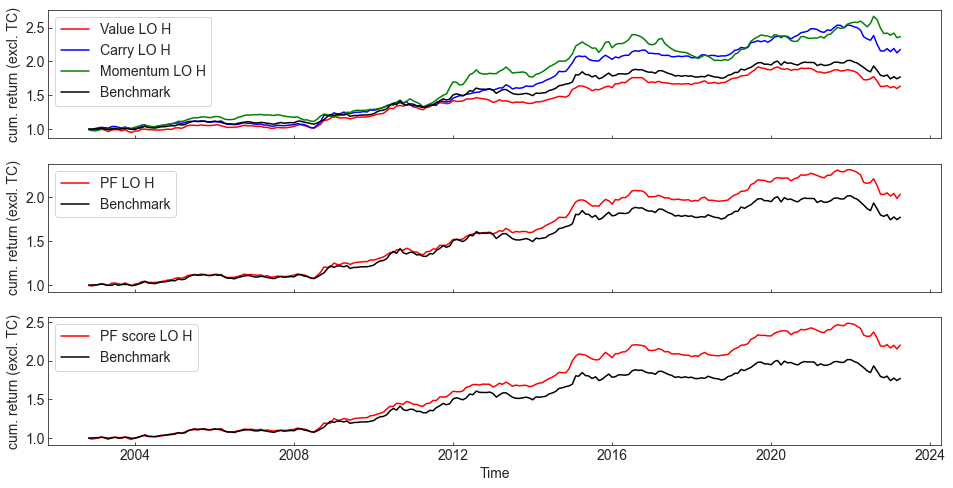

In [111]:
# all strategies against benchmark with FX or hedge
# Data
allTotalReturns = pd.concat([allTotalReturns_noTC_hedge.iloc[34:,:], Benchmark_hedge.iloc[34:], allTotalReturns_noTC_FX.iloc[34:,-1]],  axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
fig, axs = plt.subplots(3,1)
axs[0].plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO H',color="red")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO H',color="blue")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO H',color="green")
axs[0].plot(dates4Fig, strategyNAV.iloc[:,11], label='Benchmark', color="black")
axs[0].set_title("")
axs[0].legend()

#axs[1].plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS',linestyle = "dashdot",color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO H',  color="red")
axs[1].plot(dates4Fig, strategyNAV.iloc[:,11], label='Benchmark', color="black")
axs[1].set_title("")
axs[1].legend()

#axs[2].plot(dates4Fig, strategyNAV.iloc[:,8], label='PF score LS', linestyle = "dashdot", color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,9], label='PF score LO H',color="red")
axs[2].plot(dates4Fig, strategyNAV.iloc[:,11], label='Benchmark', color="black")
axs[2].set_title("")
axs[2].legend(loc = 2)


# Set the x and y axis labels and legend

for ax in axs.flat:
    ax.set(xlabel = "Time", ylabel = "cum. return (excl. TC)")
for ax in axs.flat:
    ax.label_outer()

plt.savefig("Pictures/all_5_hedged_noTC_5.png")


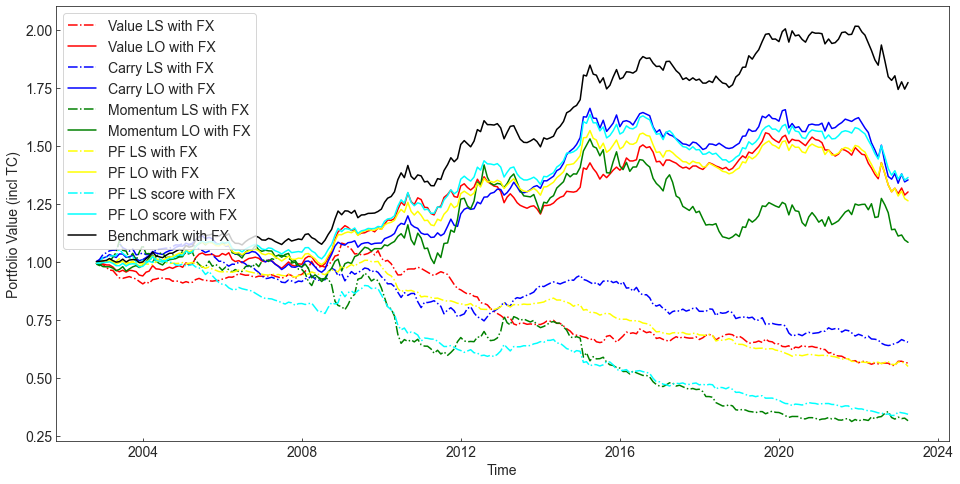

In [81]:
# All FX
# Data
allTotalReturns = pd.concat([allTotalReturns_TC_FX.iloc[34:,:], allTotalReturns_Benchmark.iloc[34:,:]], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,0], label='Value LS with FX', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO with FX',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,2], label='Carry LS with FX', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO with FX',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LS with FX', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO with FX',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS with FX', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO with FX',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,8], label='PF LS score with FX', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,9], label='PF LO score with FX',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,13], label='Benchmark with FX', color="black")


# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

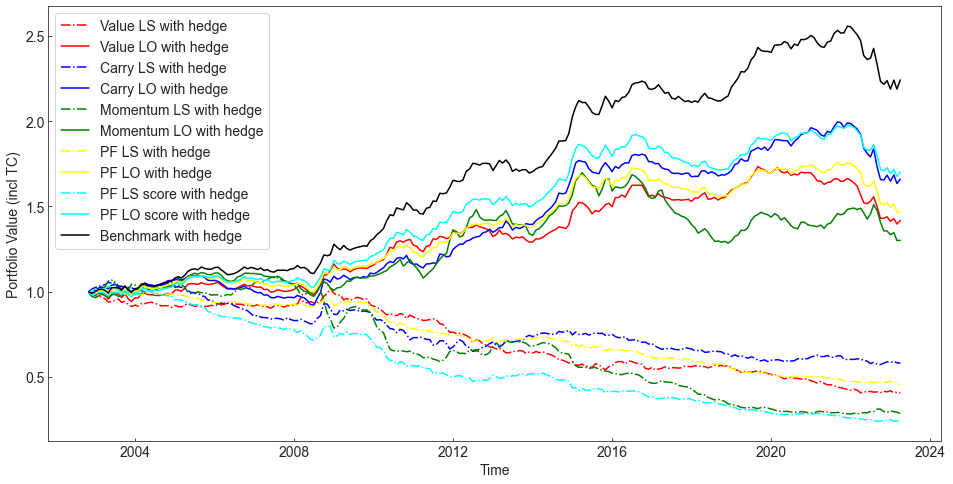

In [82]:
# All hedge
# Data
allTotalReturns = pd.concat([allTotalReturns_TC_hedge.iloc[34:,:], allTotalReturns_Benchmark.iloc[34:,:]], axis = 1)
# Dates
dates4Fig = allTotalReturns.index
# cum product
strategyNAV = np.cumprod(1 + allTotalReturns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,0], label='Value LS with hedge', linestyle='dashdot',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,1], label='Value LO with hedge',color="red")
plt.plot(dates4Fig, strategyNAV.iloc[:,2], label='Carry LS with hedge', linestyle='dashdot',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,3], label='Carry LO with hedge',color="blue")
plt.plot(dates4Fig, strategyNAV.iloc[:,4], label='Momentum LS with hedge', linestyle='dashdot',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,5], label='Momentum LO with hedge',color="green")
plt.plot(dates4Fig, strategyNAV.iloc[:,6], label='PF LS with hedge', linestyle='dashdot',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,7], label='PF LO with hedge',color="yellow")
plt.plot(dates4Fig, strategyNAV.iloc[:,8], label='PF LS score with hedge', linestyle='dashdot',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,9], label='PF LO score with hedge',color="aqua")
plt.plot(dates4Fig, strategyNAV.iloc[:,15], label='Benchmark with hedge',color="black")

# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

In [83]:
allTotalReturns_noTC_FX.to_excel("Pictures/allTotalReturns_excl_TC_FX.xlsx")
allTotalReturns_noTC_hedge.to_excel("Pictures/allTotalReturns_excl_TC_hedge.xlsx")

<ipython-input-83-549225fd9c0b>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  allTotalReturns_noTC_FX.to_excel("Pictures/allTotalReturns_excl_TC_FX.xlsx")
<ipython-input-83-549225fd9c0b>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  allTotalReturns_noTC_hedge.to_excel("Pictures/allTotalReturns_excl_TC_hedge.xlsx")


# Volatility scaling

In [84]:
# we create the PF weights and the returns (as if it would just be equal weighted)
# LS
PF_weights_equal = pd.DataFrame(np.nansum([1/3*Value_weights, 1/3*Carry_weights, 1/3*Momentum_weights], axis = 0), index = Value_weights.index, columns = Value_weights.columns)
ETF_ret_vola = pd.DataFrame(0, columns = PF_weights_equal.columns, index = PF_weights_equal.index)
ETF_ret_vola.iloc[1:,:] = ETF_ret
PF_ret_equal = pd.DataFrame(np.nansum(PF_weights_equal.iloc[:,:] * ETF_ret_vola.iloc[:,:], axis = 1), index = ETF_ret_vola.index, columns = ["PF LS ret equal"])
#PF_ret_equal


# LO
PF_weights_equal_LO = pd.DataFrame(np.nansum([1/3*Value_weights_LO, 1/3*Carry_weights_LO, 1/3*Momentum_weights_LO], axis = 0), index = Value_weights_LO.index, columns = Value_weights_LO.columns)
ETF_ret_vola = pd.DataFrame(0, columns = PF_weights_equal_LO.columns, index = PF_weights_equal_LO.index)
ETF_ret_vola.iloc[1:,:] = ETF_ret
PF_ret_equal_LO = pd.DataFrame(np.nansum(PF_weights_equal_LO.iloc[:,:] * ETF_ret_vola.iloc[:,:], axis = 1), index = ETF_ret_vola.index, columns = ["PF LO ret equal"])
#PF_ret_equal

PF_ret_equal_ = pd.concat([PF_ret_equal, PF_ret_equal_LO], axis = 1)
PF_weights_equal_ = pd.concat([PF_weights_equal, PF_weights_equal_LO], axis = 1)

In [85]:
# scaling for the three strategies

vola_weights = pd.DataFrame(columns = PF_weights_equal.columns, index = PF_weights_equal.index)
vola_returns = pd.DataFrame(columns = PF_ret_equal.columns, index = PF_ret_equal.index)
vola_weights.iloc[:12,:] = PF_weights_equal.iloc[:12,:]
vola_returns.iloc[:12,:] = PF_ret_equal.iloc[:12,:]


for i,k in enumerate(Value_ret.index):
    if i < 12:
        continue
    elif i == (len(Value_ret.index)-1):
        break
    value_sd = np.nanstd(Value_ret.iloc[i-12:i,0])
    carry_sd = np.nanstd(Carry_ret.iloc[i-12:i,0])
    mom_sd = np.nanstd(Momentum_ret.iloc[i-12:i,0])
    
    value_mean = np.nanmean(Value_ret.iloc[i-12:i,0])
    carry_mean = np.nanmean(Carry_ret.iloc[i-12:i,0])
    mom_mean = np.nanmean(Momentum_ret.iloc[i-12:i,0])
    
    nominator_value = value_mean/value_sd
    nominator_carry = carry_mean/carry_sd
    nominator_mom = mom_mean/mom_sd
    
    #PF_sd = value_sd + carry_sd + mom_sd
    PF_sd = np.nanstd(vola_returns.iloc[i-12:i,:])
    PF_mean = np.nanmean(vola_returns.iloc[i-12:i,:])
    
    denominator = PF_mean/PF_sd
    #print(PF_sd, PF_mean, denominator)
    
    factor_value = float(nominator_value / denominator)
    factor_carry = float(nominator_carry / denominator)
    factor_mom = float(nominator_mom / denominator)
    #print(nominator_value,nominator_carry,nominator_mom)
    
    if math.isnan(factor_value):
        factor_value = 1/3
    if math.isnan(factor_carry):
        factor_carry = 1/3
    if math.isnan(factor_mom):
        factor_mom = 1/3

    if factor_value < 0:
        factor_value = 1/3
    if  factor_carry < 0:
        factor_carry = 1/3
    if  factor_mom < 0:
        factor_mom = 1/3
        
    factor_value = min(factor_value, 5)
    factor_value = max(factor_value, -5)
    factor_carry = min(factor_value, 5)
    factor_carry = max(factor_value, -5)
    factor_mom = min(factor_value, 5)
    factor_mom = max(factor_value, -5)


    vola_weights.iloc[i,:] = np.nansum([factor_value*Value_weights.iloc[i,:], factor_carry*Carry_weights.iloc[i,:], factor_mom*Momentum_weights.iloc[i,:]], axis = 0)
    vola_returns.iloc[i,:] = np.nansum(np.multiply(vola_weights.iloc[i,:], ETF_ret.iloc[i,:]), axis = 0)
    
vola_weights
    

<ipython-input-85-6215c6037001>:22: RuntimeWarning: invalid value encountered in double_scalars
  nominator_value = value_mean/value_sd
<ipython-input-85-6215c6037001>:24: RuntimeWarning: invalid value encountered in double_scalars
  nominator_mom = mom_mean/mom_sd


,Germany,France,Spain,Italy,UK,Switzerland,China,Australia,Japan,USA,Canada,Singapore,India
Datum,,,,,,,,,,,,,
1999-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-31,0.066667,0.066667,0.066667,0.066667,-0.066667,0.0,0.0,0.066667,-0.066667,0.0,0.0,0.0,0.0
2000-02-29,0.066667,0.066667,0.066667,0.066667,-0.066667,0.0,0.0,-0.066667,-0.066667,0.0,0.0,0.066667,0.0
2000-03-31,-0.066667,0.066667,0.066667,0.066667,-0.066667,0.0,0.0,-0.066667,0.066667,0.0,0.0,0.066667,0.0
2000-04-28,-0.066667,0.066667,0.066667,0.066667,-0.066667,0.0,0.0,-0.066667,0.066667,0.0,0.0,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.2,0.066667,0.0,-0.066667,-0.133333,0.066667,0.2,0.133333,0.133333,-0.066667,-0.066667,0.0,-0.066667
2022-12-30,-0.2,0.066667,0.0,-0.066667,-0.133333,0.066667,0.133333,0.2,0.133333,-0.066667,-0.066667,0.0,-0.066667
2023-01-31,-0.2,0.066667,0.0,-0.066667,-0.133333,0.066667,0.2,0.133333,0.133333,-0.066667,-0.066667,0.0,-0.066667


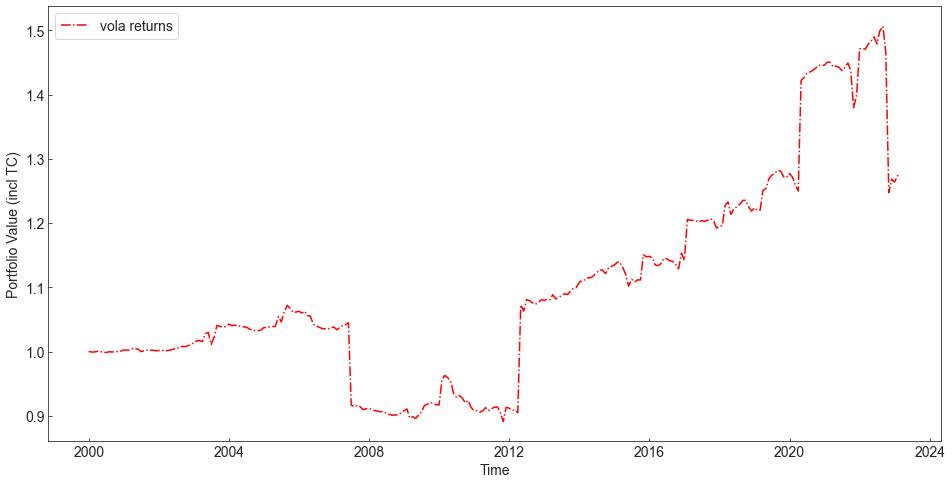

In [86]:
# All hedge
# Data
# Dates
dates4Fig = vola_returns.index
# cum product
strategyNAV = np.cumprod(1 + vola_returns)
# Create the line plot
plt.plot(dates4Fig, strategyNAV.iloc[:,0], label='vola returns', linestyle='dashdot',color="red")


# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

# Show the plot
plt.show()

In [87]:
vola_returns

,PF LS ret equal
Datum,
1999-12-31,0.0
2000-01-31,-0.000712
2000-02-29,0.000042
2000-03-31,0.00092
2000-04-28,-0.000387
...,...
2022-11-30,0.016686
2022-12-30,-0.003502
2023-01-31,0.008015


In [88]:
Carry_returns

,Germany,France,Spain,Italy,UK,Switzerland,China,Australia,Japan,USA,Canada,Singapore,India
Datum,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-31,-0.000834,-0.001076,-0.000758,-0.000452,0.001729,NaN,NaN,-0.000533,-0.000212,NaN,NaN,NaN,NaN
2000-02-29,0.001333,0.001196,0.001141,0.001189,-0.003594,NaN,NaN,-0.004268,0.001072,NaN,NaN,0.002058,NaN
2000-03-31,-0.003291,0.003321,0.003214,0.002778,-0.002342,NaN,NaN,-0.002583,0.000745,NaN,NaN,0.000917,NaN
2000-04-28,0.000074,-0.000074,-0.000037,0.000056,-0.002079,NaN,NaN,-0.000798,0.000674,NaN,NaN,0.001023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,-0.004171,0.004249,0.004081,0.005485,0.0,0.000633,0.002925,0.002811,-0.0,0.0,-0.005641,-0.004892,-0.007123
2022-12-30,0.008003,-0.009326,-0.007987,-0.009009,-0.0,0.005238,0.006097,-0.004419,-0.0,-0.0,0.003361,-0.002719,0.002952
2023-01-31,-0.003334,0.004431,0.003748,0.006449,0.0,-0.002987,0.005444,0.005803,-0.0,0.0,-0.005989,0.000347,-0.00324


In [89]:
PF_ret_equal

,PF LS ret equal
Datum,
1999-12-31,0.0
2000-01-31,-0.000712
2000-02-29,0.000042
2000-03-31,0.00092
2000-04-28,-0.000387
...,...
2022-11-30,-0.010797
2022-12-30,0.011435
2023-01-31,-0.002626


In [90]:
all_all = pd.concat([Value_weights_LO, Carry_weights_LO, Momentum_weights_LO],axis = 1)
all_all.to_excel("Vola_hedging/excel_for_vola.xlsx")

<ipython-input-90-884b02c97449>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  all_all.to_excel("Vola_hedging/excel_for_vola.xlsx")


In [91]:
Value_weights_LO

,Germany,France,Spain,Italy,UK,Switzerland,China,Australia,Japan,USA,Canada,Singapore,India
Datum,,,,,,,,,,,,,
1999-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-31,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-02-29,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-03-31,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-04-28,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,0.0,0.2,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0
2022-12-30,0.0,0.2,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0
2023-01-31,0.0,0.2,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0


# Vola scaling

In [92]:
# rawdata is direct import from excel

# Import of excel data, sheet by sheet
xls_vola = pd.ExcelFile("Vola_hedging/excel_for_vola_edited.xlsx")

vola_raw = pd.DataFrame(pd.read_excel(xls_vola, 3))

# keep a safe copy of the rawdata to compare the changes
vola = vola_raw.copy()

# Set date as index
vola.set_index("Datum", inplace=True)

In [93]:
vola_PF = vola.loc[:,"PF cumulative"]
vola_2 = vola.loc[:, 'PF return']

In [94]:
B_FX = np.cumprod(1+allTotalReturns_TC_FX.loc['2003-10-31':,'Benchmark FX incl. TC'])
PF_b = np.cumprod(1+allTotalReturns_TC_FX.loc['2003-10-31':,'PF LO TC'])
PF_s = np.cumprod(1+allTotalReturns_TC_FX.loc['2003-10-31':,'PF score LO TC'])

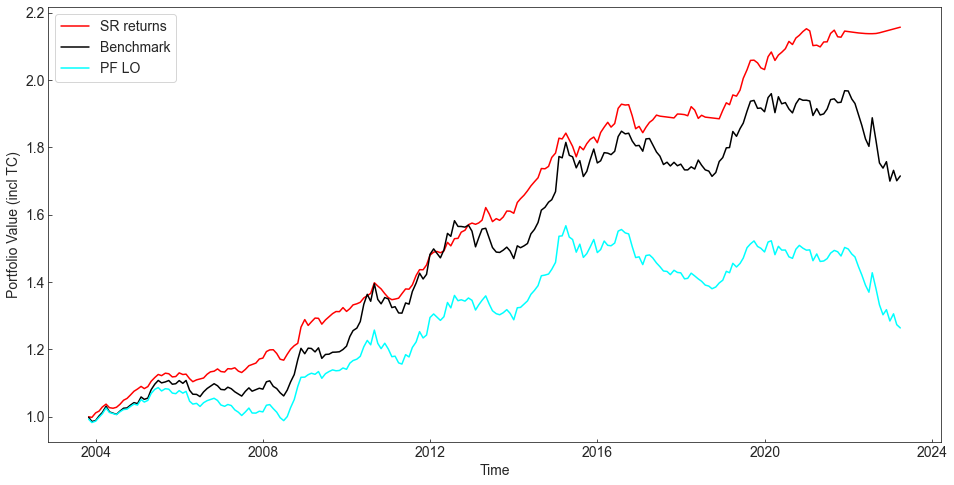

In [99]:
# All hedge
# Data
# Dates
dates4Fig = vola_PF.index
dates4Fig = dates4Fig[11:]
# cum product
strategyNAV = vola_PF.iloc[11:]
# Create the line plot
plt.plot(dates4Fig, strategyNAV, label='SR returns',color="red")
plt.plot(dates4Fig, B_FX, label='Benchmark', color="black")
plt.plot(dates4Fig, PF_b, label='PF LO', color="aqua")
#plt.plot(dates4Fig, PF_s, label='PF score LO', color="green")


# Set the x and y axis labels and legend
plt.xlabel('Time')
plt.ylabel('Portfolio Value (incl TC)')
plt.legend()

plt.savefig("Pictures/vola_scaling_LO.png")
# Show the plot
plt.show()



# Fama French reg

In [96]:
# first we need to load the data and add the FX return for USD
# load

# Import of excel data, sheet by sheet
xls_ff = pd.ExcelFile("1_Data/Data Clean TM/Fama_french.xlsx")

ff_raw = pd.DataFrame(pd.read_excel(xls_ff, 0))

# keep a safe copy of the rawdata to compare the changes
ff = ff_raw.copy()

# Set date as index
ff.set_index("Dates(eom)", inplace=True)

# align dates
ff = ff.iloc[36:,:]

In [97]:
# now we extract the USD/EUR exchange rate
USD = FX_ret.loc[:,"USA"]
USD = USD.iloc[46:-2]

# and calculate the EUR returns of ff
ff_EUR = pd.DataFrame(columns = ff.columns, index = ff.index)

for i,k in enumerate(ff.index):
    for j,l in enumerate(ff.columns):
        ff_EUR.iloc[i,j] = ff.iloc[i,j] + USD.iloc[i]

In [98]:
# now the regression
x = ff_EUR
x3 = x.copy()
x3 = x3.iloc[12:]
y = allTotalReturns_FX.iloc[35:-1,7]
y2 = allTotalReturns_FX.iloc[35:-1,9]
y3 = vola_2.iloc[12:-1]
reg = LinearRegression().fit(x,y)
reg2 = LinearRegression().fit(x,y2)
reg3 = LinearRegression().fit(x3,y3)

# print results
# print(reg.intercept_)
# print(reg.coef_)
# print(reg.score(x,y))

# with statsmodels
x = x.astype(float)
y = y.astype(float)
y2 = y2.astype(float)
y3 = y3.astype(float)
x.set_index(y.index, inplace = True)
x = sm.add_constant(x) # adding a constant
x3 = x.copy()
x3 = x3.iloc[12:]
 
model = sm.OLS(y, x).fit()
 
print_model = model.summary()
print(print_model)

model = sm.OLS(y2, x).fit()
 
print_model = model.summary()
print(print_model)

model = sm.OLS(y3, x3).fit()
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:               PF LO FX   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     49.37
Date:                Mon, 15 May 2023   Prob (F-statistic):           6.87e-25
Time:                        16:39:39   Log-Likelihood:                 872.07
No. Observations:                 244   AIC:                            -1736.
Df Residuals:                     240   BIC:                            -1722.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.374      0.7

C:\Users\Corinne Vogel\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
